In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import OrdinalEncoder, Normalizer
from sklearn.metrics import (balanced_accuracy_score,
                             recall_score, f1_score,
                             precision_score,
                             r2_score,
                             roc_curve,
                             auc)
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)

## Import the dataset
In this Notebook we are working with the UGR'16 dataset.  
We will not use the entire dataset but just a sample of the [July 2016 dataset](https://nesg.ugr.es/nesg-ugr16/july.php#INI). We have recovered one line out of 50 as the sample.

In [2]:
path = "datasets/sample.july.week5.pkl"
dataset = pd.read_pickle(path)

## Dataset structure

We are going to analyse the structure of the dataset and if necessary reformat the dataset.

In [3]:
dataset.head()

2016-07-27 13:43:29  0.000    143.72.8.137   42.219.153.89     53  49486  \
0  2016-07-27 13:43:29    0.0    143.72.8.137  42.219.158.161     53  43192   
1  2016-07-27 13:43:29    0.0   204.97.46.121   42.219.153.62  59951     53   
2  2016-07-27 13:43:29    0.0  42.219.152.249  37.235.128.133  59993     53   
3  2016-07-27 13:43:29    0.0   42.219.153.62  37.112.206.102     53  60540   
4  2016-07-27 13:43:29    0.0  42.219.154.104    143.72.4.250  43790     53   

   UDP  .A....  0  0.1  1   91  background  
0  UDP  .A....  0    0  1  214  background  
1  UDP  .A....  0    0  1  106  background  
2  UDP  .A....  0    0  1   60  background  
3  UDP  .A....  0    0  1  144  background  
4  UDP  .A....  0    0  1   59  background

In [4]:
dataset.shape

(10789816, 13)

We can see that the dataset has no column name and that there are 10,789,816 rows and 13 columns.  
In the page 8 section *D. Dataset Preprocessing and Availability* of the [UGR’16 paper](https://nesg.ugr.es/nesg-ugr16/dataset_AuthorVersionFinal.pdf) we can find the name of the columns. <br> <br>

![URG'16](images/column_name.png) <br> <br>

So we are going to rename the columns with the following names:
- Timestamp of the end of a flow: **dateTime**
- Duration of the flow: **duration**
- Source IP Address : **srcIP**
- Destination IP Address: **dstIP**
- Source Port: **srcPort**
- Destination Port: **dstPort**
- Protocol: **protocol**
- Flag: **flag**
- Forwarding status: **forwardingStatus**
- Type of Service (ToS) byte: **tos**
- Packets exchanged: **packets**
- Bytes exchanged: **bytes**
- Label: **label**

In [5]:
dataset.columns = ['dateTime', 'duration', 'srcIP', 'dstIP', 'srcPort', 'dstPort',
                   'protocol', 'flag', 'forwardingStatus', 'tos', 'packets', 'bytes', 'label']

In [6]:
dataset.head()

dateTime  duration           srcIP           dstIP  srcPort  \
0  2016-07-27 13:43:29       0.0    143.72.8.137  42.219.158.161       53   
1  2016-07-27 13:43:29       0.0   204.97.46.121   42.219.153.62    59951   
2  2016-07-27 13:43:29       0.0  42.219.152.249  37.235.128.133    59993   
3  2016-07-27 13:43:29       0.0   42.219.153.62  37.112.206.102       53   
4  2016-07-27 13:43:29       0.0  42.219.154.104    143.72.4.250    43790   

   dstPort protocol    flag  forwardingStatus  tos  packets  bytes       label  
0    43192      UDP  .A....                 0    0        1    214  background  
1       53      UDP  .A....                 0    0        1    106  background  
2       53      UDP  .A....                 0    0        1     60  background  
3    60540      UDP  .A....                 0    0        1    144  background  
4       53      UDP  .A....                 0    0        1     59  background

In [7]:
dataset.label.unique()

array(['background', 'blacklist', 'anomaly-spam', 'dos', 'scan11',
       'scan44', 'nerisbotnet', 'anomaly-sshscan'], dtype=object)

The column *label* indicates if there were an anomaly or not. There are 8 different values (*background, blacklist, anomaly-spam, dos, scan11, scan44, nerisbotnet, anomaly-sshscan*).

The attack labeled *blacklist* is a bit special. In this case, we recognize the attack based on a list of blacklisted Ips. Thus, we will remove this attack from the dataset.

In [8]:
dataset = dataset[dataset.label != "blacklist"].reset_index().drop("index", axis=1)
dataset.head()

dateTime  duration           srcIP           dstIP  srcPort  \
0  2016-07-27 13:43:29       0.0    143.72.8.137  42.219.158.161       53   
1  2016-07-27 13:43:29       0.0   204.97.46.121   42.219.153.62    59951   
2  2016-07-27 13:43:29       0.0  42.219.152.249  37.235.128.133    59993   
3  2016-07-27 13:43:29       0.0   42.219.153.62  37.112.206.102       53   
4  2016-07-27 13:43:29       0.0  42.219.154.104    143.72.4.250    43790   

   dstPort protocol    flag  forwardingStatus  tos  packets  bytes       label  
0    43192      UDP  .A....                 0    0        1    214  background  
1       53      UDP  .A....                 0    0        1    106  background  
2       53      UDP  .A....                 0    0        1     60  background  
3    60540      UDP  .A....                 0    0        1    144  background  
4       53      UDP  .A....                 0    0        1     59  background

We will consider the label *background* as normal and the others (*anomaly-spam, dos, scan11, scan44, nerisbotnet, anomaly-sshscan*) as anomalies.  
Normal behaviours will have the value 0 and the normal ones the value 1.

In [9]:
dataset.label = np.where(dataset.label == "background", 0, 1)

### Columns deletion

In [10]:
dataset.forwardingStatus.unique()

array([0])

We can see that the column *forwardingStatus* has a unique value, so we can remove this column.

In [11]:
dataset = dataset.drop(columns=["forwardingStatus"])

Also we are going to remove the *srcIP* and *dstIP* columns.

In [12]:
dataset = dataset.drop(columns=["srcIP", "dstIP"])

### Transformation of the dateTime column

We are going to encode the dateTime column in order to use it.

In [13]:
dataset.dateTime = dataset.dateTime.astype("datetime64").apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

### Check if there are null values

In [14]:
dataset.isna().values.any()

False

We can see that there are no null values in the dataset.

### Final dataset

In [15]:
dataset.head()

dateTime  duration  srcPort  dstPort protocol    flag  tos  packets  bytes  \
0     49409       0.0       53    43192      UDP  .A....    0        1    214   
1     49409       0.0    59951       53      UDP  .A....    0        1    106   
2     49409       0.0    59993       53      UDP  .A....    0        1     60   
3     49409       0.0       53    60540      UDP  .A....    0        1    144   
4     49409       0.0    43790       53      UDP  .A....    0        1     59   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

So our final dataset has only 10 columns: *dateTime, duration, srcPort, dstPort, protocol, flag, tos, packets, bytes, label*

## Data analysis

In this section we will analyse the dataset.

In [16]:
dataset.label.value_counts(normalize=True) * 100

0    98.873591
1     1.126409
Name: label, dtype: float64

We can see that we have an unbalanced dataset. Indeed 98.9% of our data corresponds to a normal traffic and only 1.1% of the data to anomalies.
The robustness of our model will be greatly impacted by its capacity to detect anomalies.

<br>

We will now compare the distribution of the data according to their label.

In [17]:
fraud_data = dataset[dataset.label == 1]
normal_data = dataset[dataset.label == 0]

In [18]:
fraud_data.describe()

dateTime       duration        srcPort        dstPort  \
count  121212.000000  121212.000000  121212.000000  121212.000000   
mean    34307.292686       1.180018   18876.591806   10900.377751   
std     24699.843868      28.612103   21822.809283   16516.994600   
min         0.000000       0.000000       0.000000       0.000000   
25%     11359.000000       0.000000      80.000000      80.000000   
50%     24674.000000       0.000000    8136.000000    3301.000000   
75%     57702.000000       0.000000   39755.000000   13579.000000   
max     86399.000000    2691.891000   65500.000000   65500.000000   

                 tos        packets          bytes     label  
count  121212.000000  121212.000000  121212.000000  121212.0  
mean        0.156635       1.899713     199.129575       1.0  
std         3.265341       3.209140    2466.907862       0.0  
min         0.000000       1.000000      30.000000       1.0  
25%         0.000000       1.000000      40.000000       1.0  
50%         0.000000       1.000000      44.000000       1.0  
75%         0.000000       2.000000     200.000000       1.0  
max        72.000000     468.000000  322938.000000       1.0

In [19]:
normal_data.describe()

dateTime      duration       srcPort       dstPort           tos  \
count  1.063971e+07  1.063971e+07  1.063971e+07  1.063971e+07  1.063971e+07   
mean   4.714601e+04  4.960298e+00  2.406415e+04  2.023511e+04  9.622220e+00   
std    2.449109e+04  2.530250e+01  2.401434e+04  2.399640e+04  2.368298e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.722200e+04  0.000000e+00  8.000000e+01  8.000000e+01  0.000000e+00   
50%    5.014300e+04  2.560000e-01  1.692700e+04  9.930000e+02  0.000000e+00   
75%    6.781900e+04  2.984000e+00  4.933600e+04  4.676100e+04  0.000000e+00   
max    8.639900e+04  3.619520e+02  6.553500e+04  6.553500e+04  2.240000e+02   

            packets         bytes       label  
count  1.063971e+07  1.063971e+07  10639714.0  
mean   2.383176e+01  1.766754e+04         0.0  
std    2.699800e+03  3.667925e+06         0.0  
min    1.000000e+00  2.100000e+01         0.0  
25%    1.000000e+00  8.700000e+01         0.0  
50%    2.000000e+00  1.970000e+02         0.0  
75%    8.000000e+00  1.150000e+03         0.0  
max    2.868994e+06  4.294966e+09         0.0

In [20]:
def distribution(dataset_normal, dataset_anomaly, feature, head=10):
    a = dataset_normal[feature].value_counts(normalize=True).head(head) * 100
    b = dataset_anomaly[feature].value_counts(normalize=True).head(head) * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    m = max(max(a), max(b))
    
    a.plot.bar(title="Normal traffic", ax=ax1)
    ax1.set_ylim(0, m * 1.1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel("% of occurrence")

    b.plot.bar(title="Fraudulent traffic", ax=ax2)
    ax2.set_ylim(0, m * 1.1)
    ax2.set_xlabel(feature)
    ax2.set_ylabel("% of occurrence")
    
    plt.show()
    
    return a, b

def compare_distribution(normal, fraud, feature):
    print(f"Comparison between normal and fraudulent traffic for the: {feature}")
    print(f"Normal traffic: {round(normal.sum(), 3)}% - Fraudulent traffic: {round(fraud.sum(), 3)}%", end="\n\n")
    
    for i in fraud.index:
        if i in normal.index:
            print(f"flag = {i}: Fraud = {round(fraud[i], 3)}% | Normal = {round(normal[i], 3)}%")
        else:
            print(f"flag = {i}: Fraud = {round(fraud[i], 3)}%")

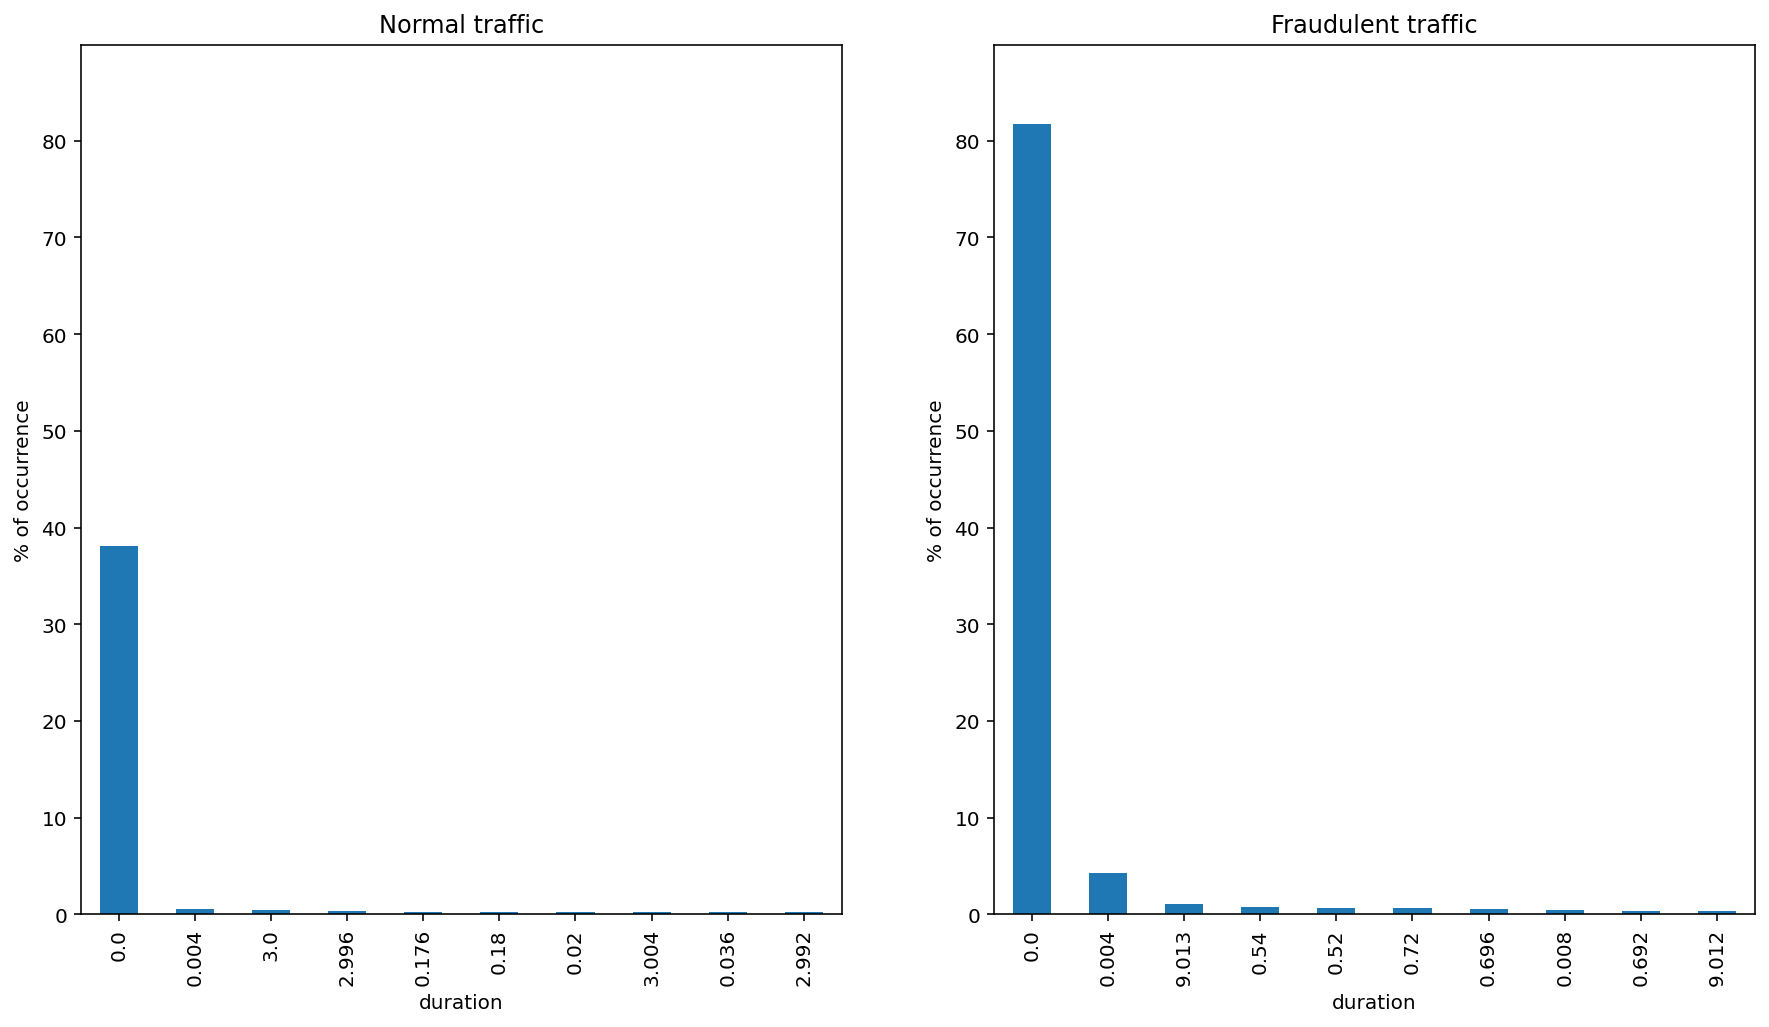

In [21]:
_ = distribution(normal_data, fraud_data, "duration")

We can observe that more than 80% of the duration of the flow of the anomalies was 0 seconde

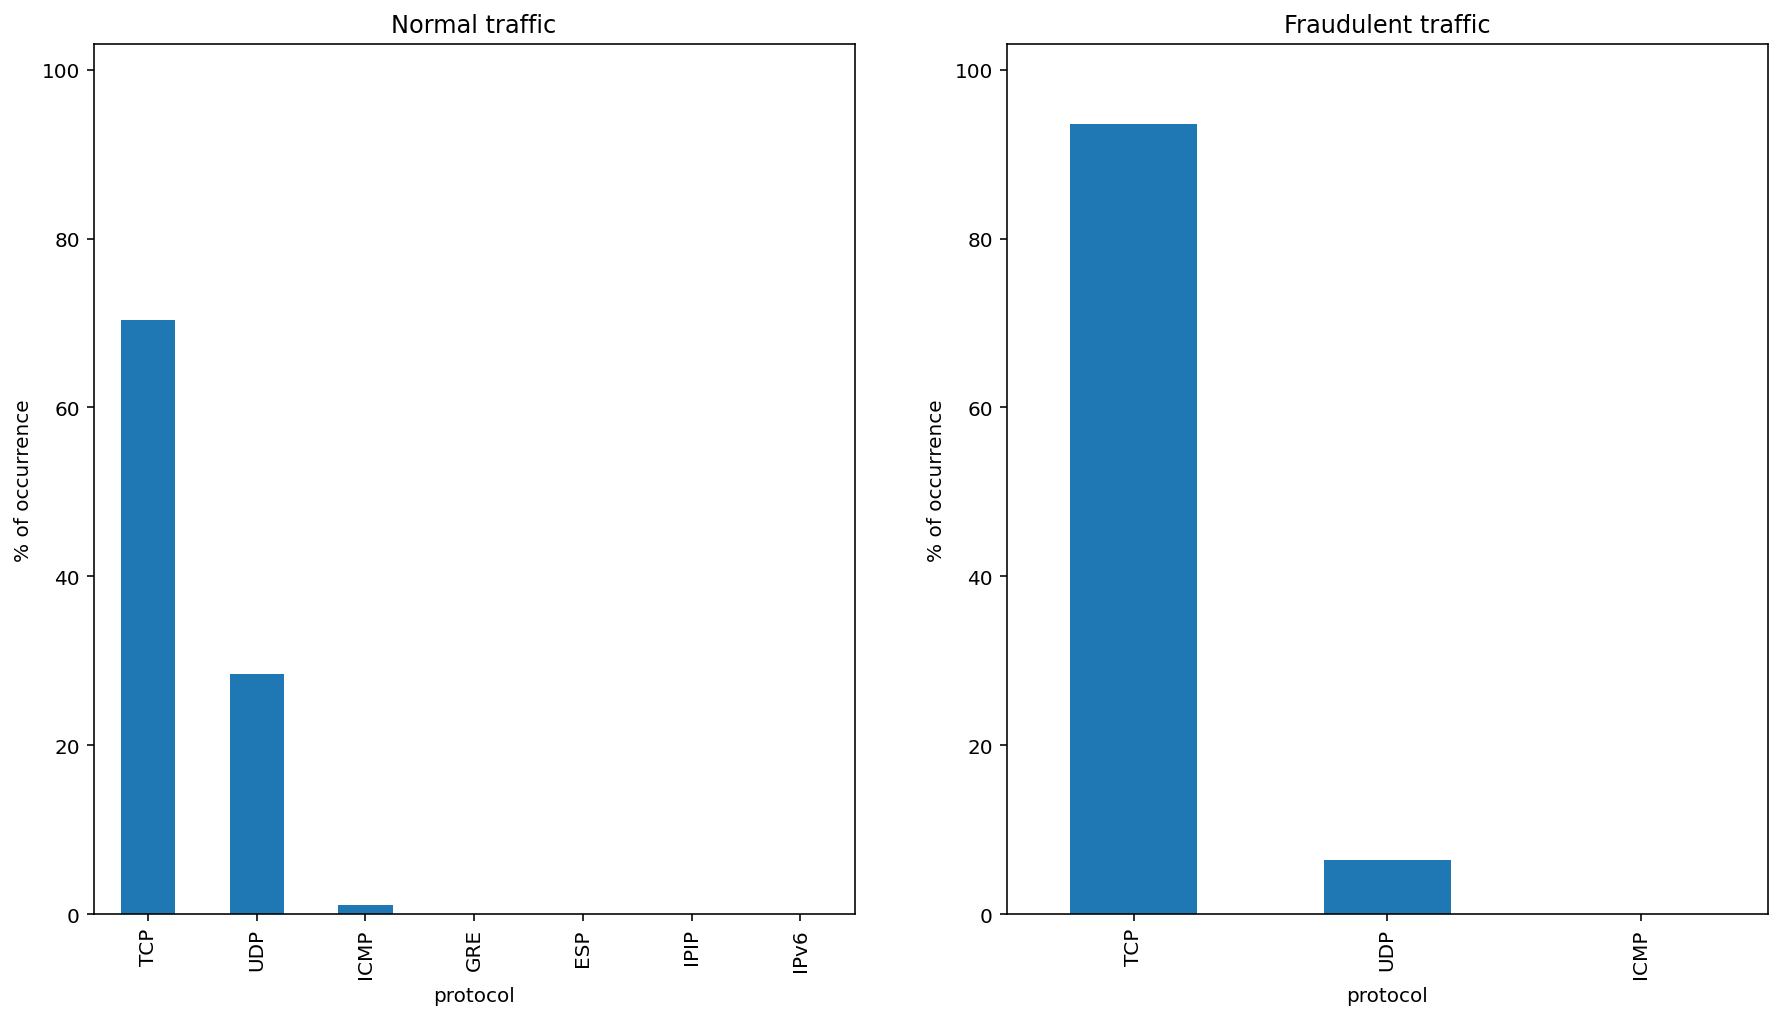

In [22]:
_ = distribution(normal_data, fraud_data, "protocol")

100% of the fraudulent traffic uses the protocols TCP, UDP and ICMP

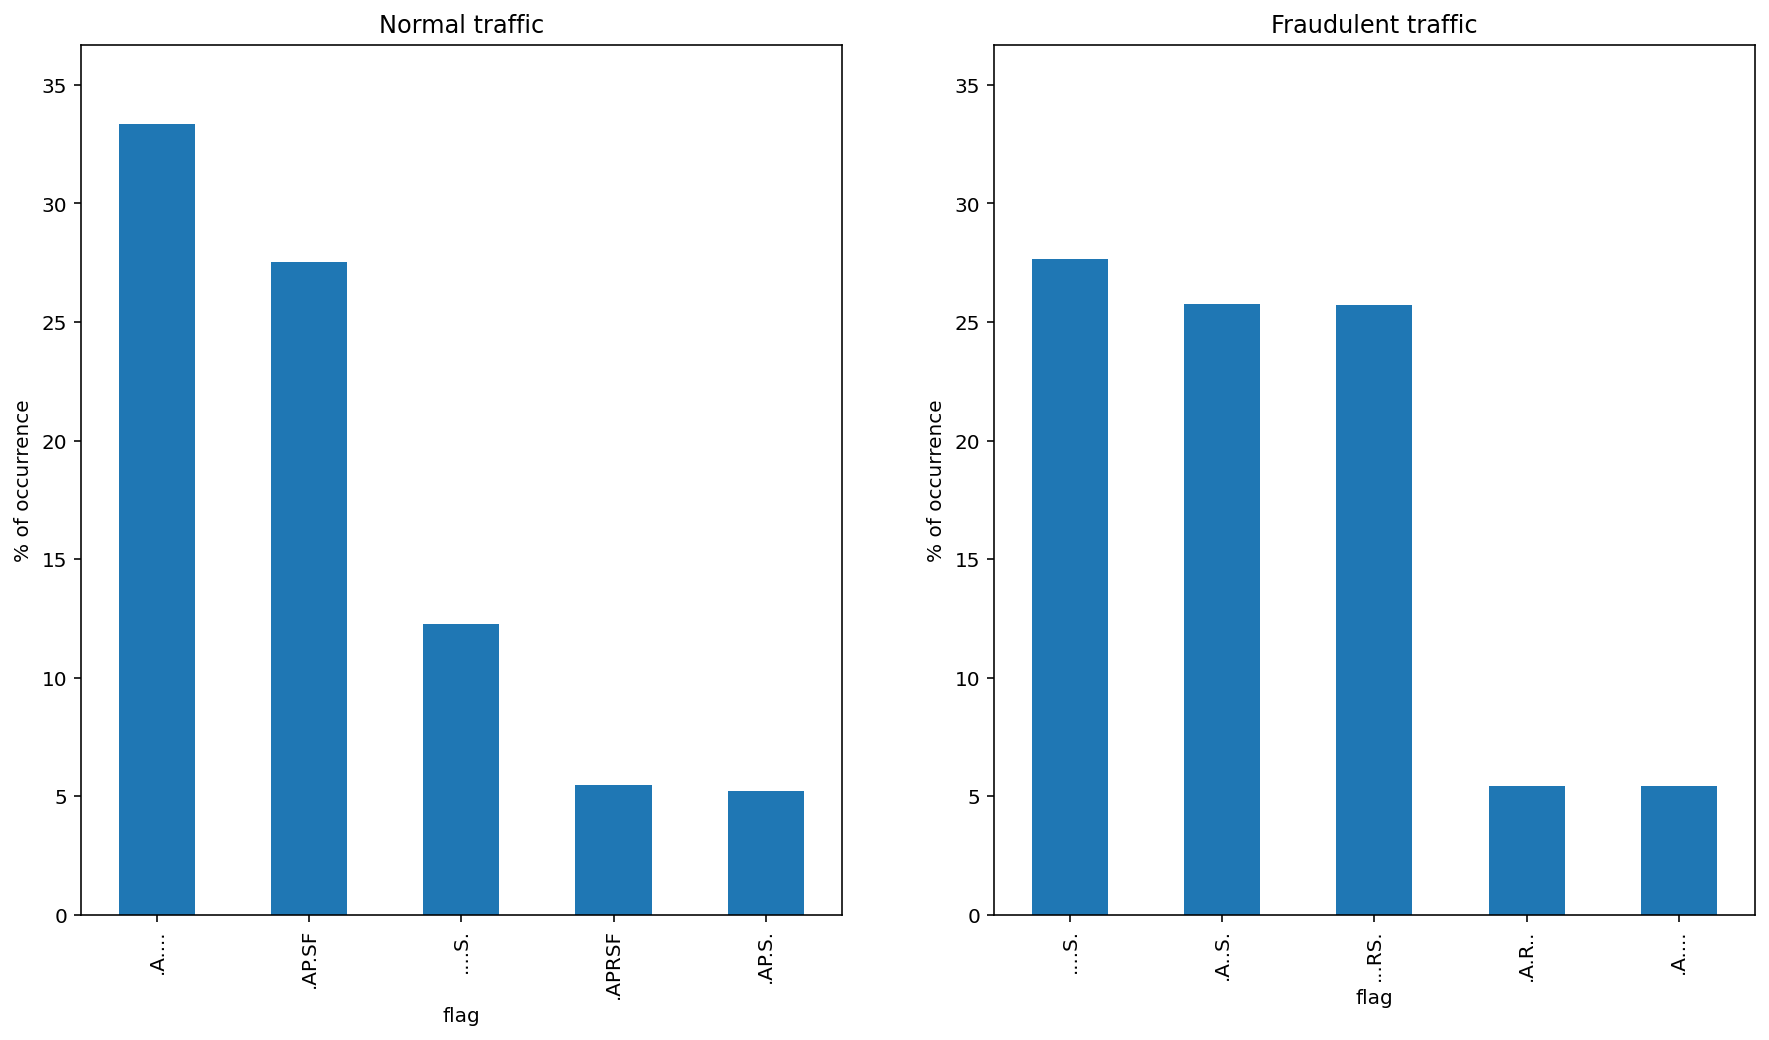

In [23]:
normal_flag, fraud_flag = distribution(normal_data, fraud_data, "flag", 5)

In [24]:
compare_distribution(normal_flag, fraud_flag, "flag")

Comparison between normal and fraudulent traffic for the: flag
Normal traffic: 83.853% - Fraudulent traffic: 89.956%

flag = ....S.: Fraud = 27.642% | Normal = 12.244%
flag = .A..S.: Fraud = 25.761%
flag = ...RS.: Fraud = 25.7%
flag = .A.R..: Fraud = 5.429%
flag = .A....: Fraud = 5.424% | Normal = 33.357%


We observe that 90% of the fraudulent traffic uses 5 different flags.

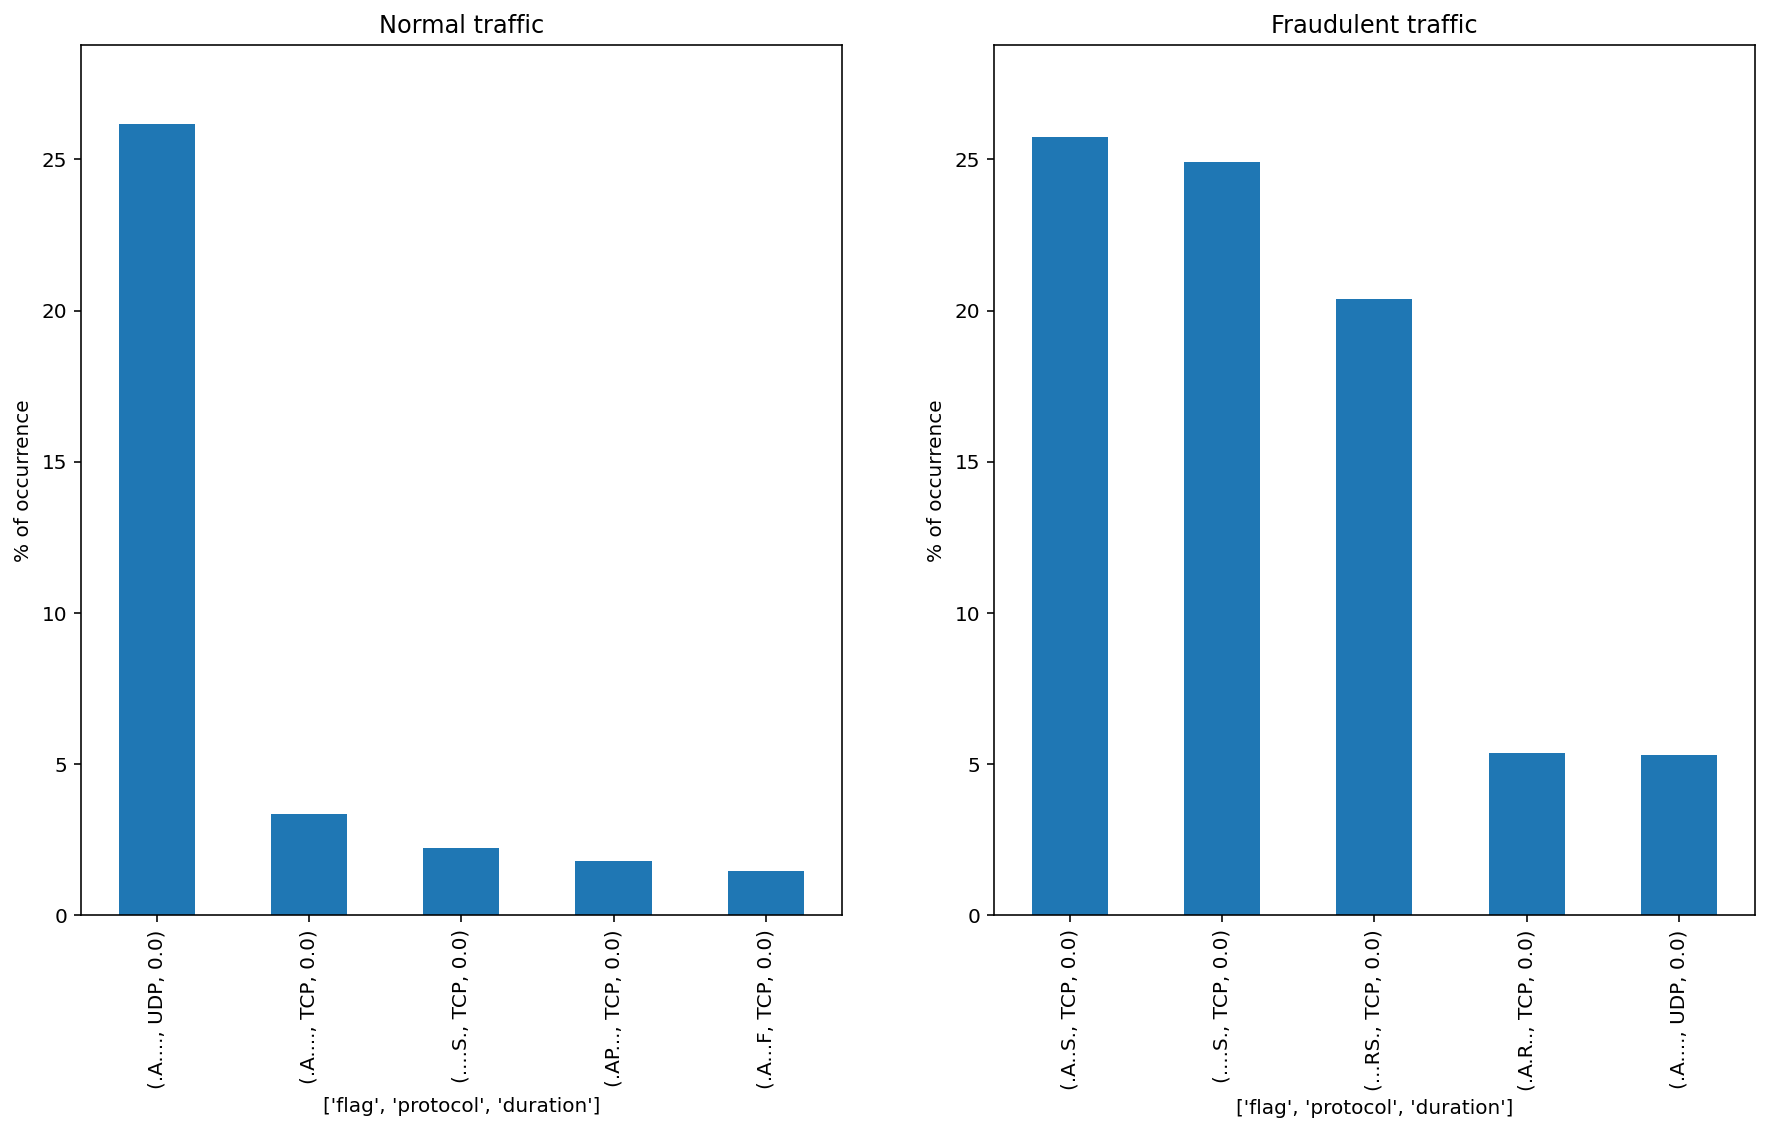

In [25]:
normal_mul, fraud_mul = distribution(normal_data, fraud_data, ["flag", "protocol", "duration"], 5)

In [26]:
compare_distribution(normal_mul, fraud_mul, ["flag", "protocol", "duration"])

Comparison between normal and fraudulent traffic for the: ['flag', 'protocol', 'duration']
Normal traffic: 34.959% - Fraudulent traffic: 81.734%

flag = ('.A..S.', 'TCP', 0.0): Fraud = 25.752%
flag = ('....S.', 'TCP', 0.0): Fraud = 24.932% | Normal = 2.216%
flag = ('...RS.', 'TCP', 0.0): Fraud = 20.374%
flag = ('.A.R..', 'TCP', 0.0): Fraud = 5.371%
flag = ('.A....', 'UDP', 0.0): Fraud = 5.306% | Normal = 26.169%


With only 5 combinations of flags, protocol and duration we can detect 82% of the fraudulent traffic.

In [27]:
def distribution_hist(dataset_normal, dataset_anomaly, feature, bins=100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    dataset_normal[feature].hist(ax=ax1, bins=bins)
    dataset_anomaly[feature].hist(ax=ax2, bins=bins)
    
    ax1.set_title("Normal traffic")
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Number of occurrence")
    
    ax2.set_title("Fraudulent traffic")
    ax2.set_xlabel(feature)
    ax2.set_ylabel("Number of occurrence")
    
    plt.show()

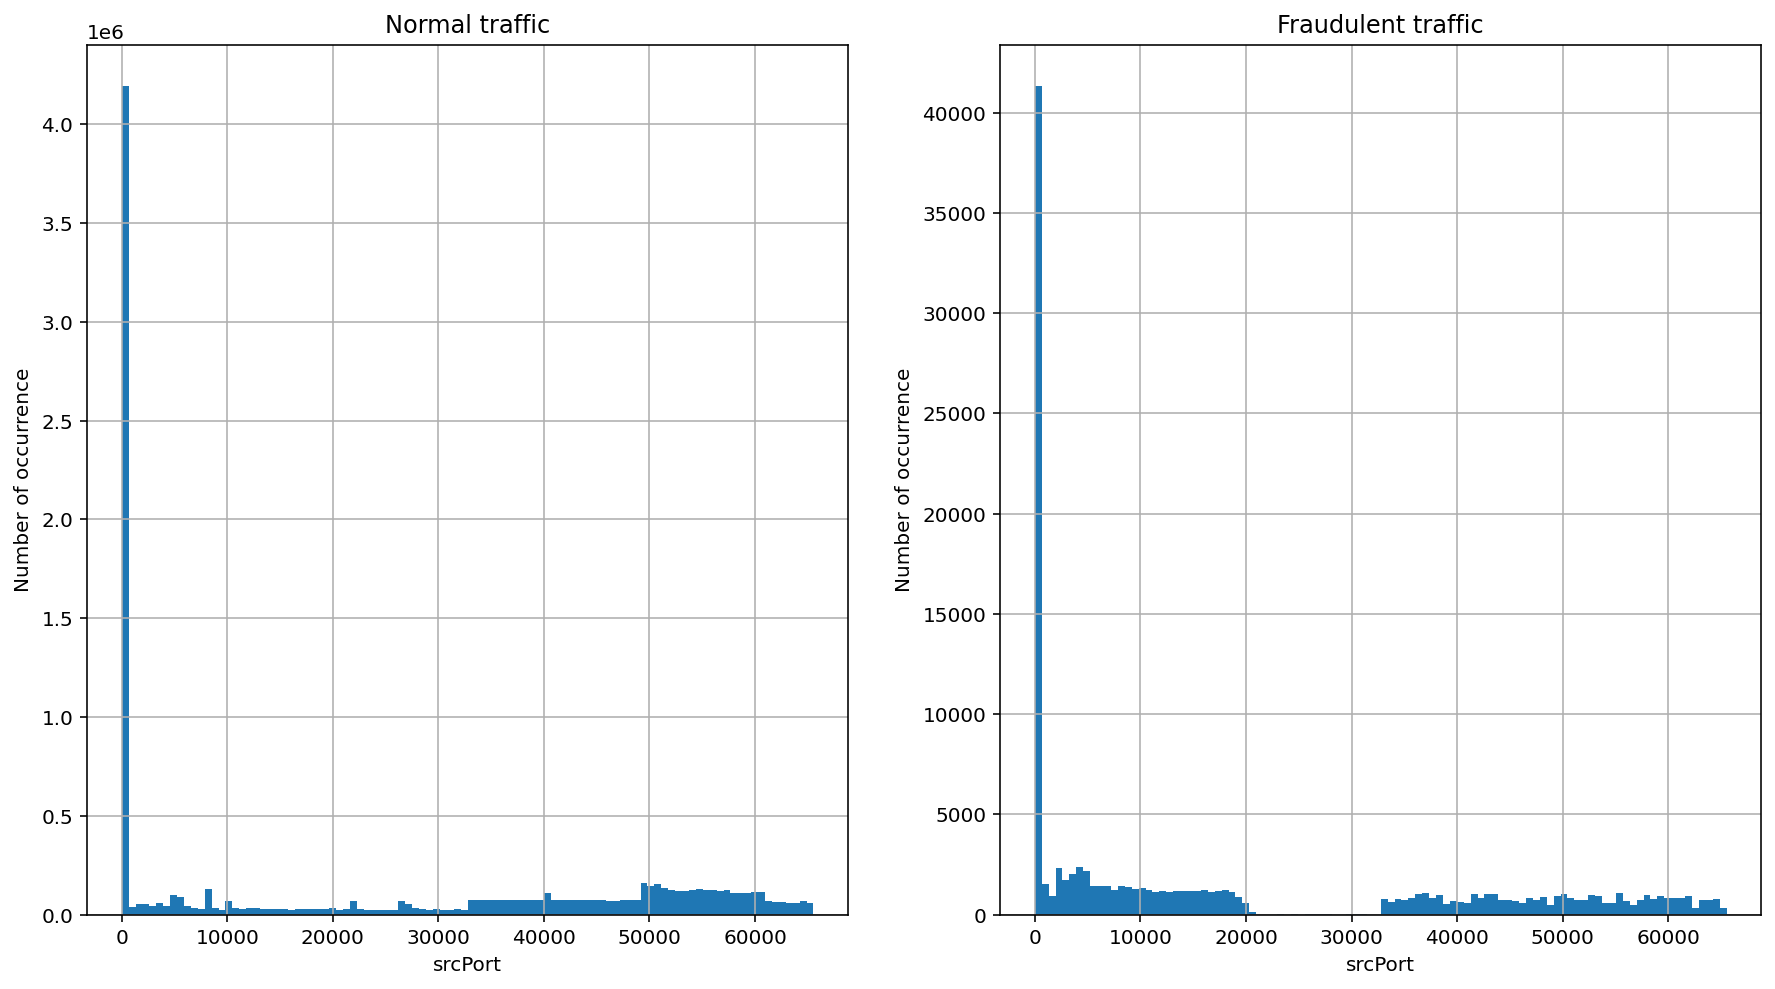

In [28]:
distribution_hist(normal_data, fraud_data, "srcPort", 100)

We can observe that there is almost no fraudulent traffic between source ports 20000 and 32000.

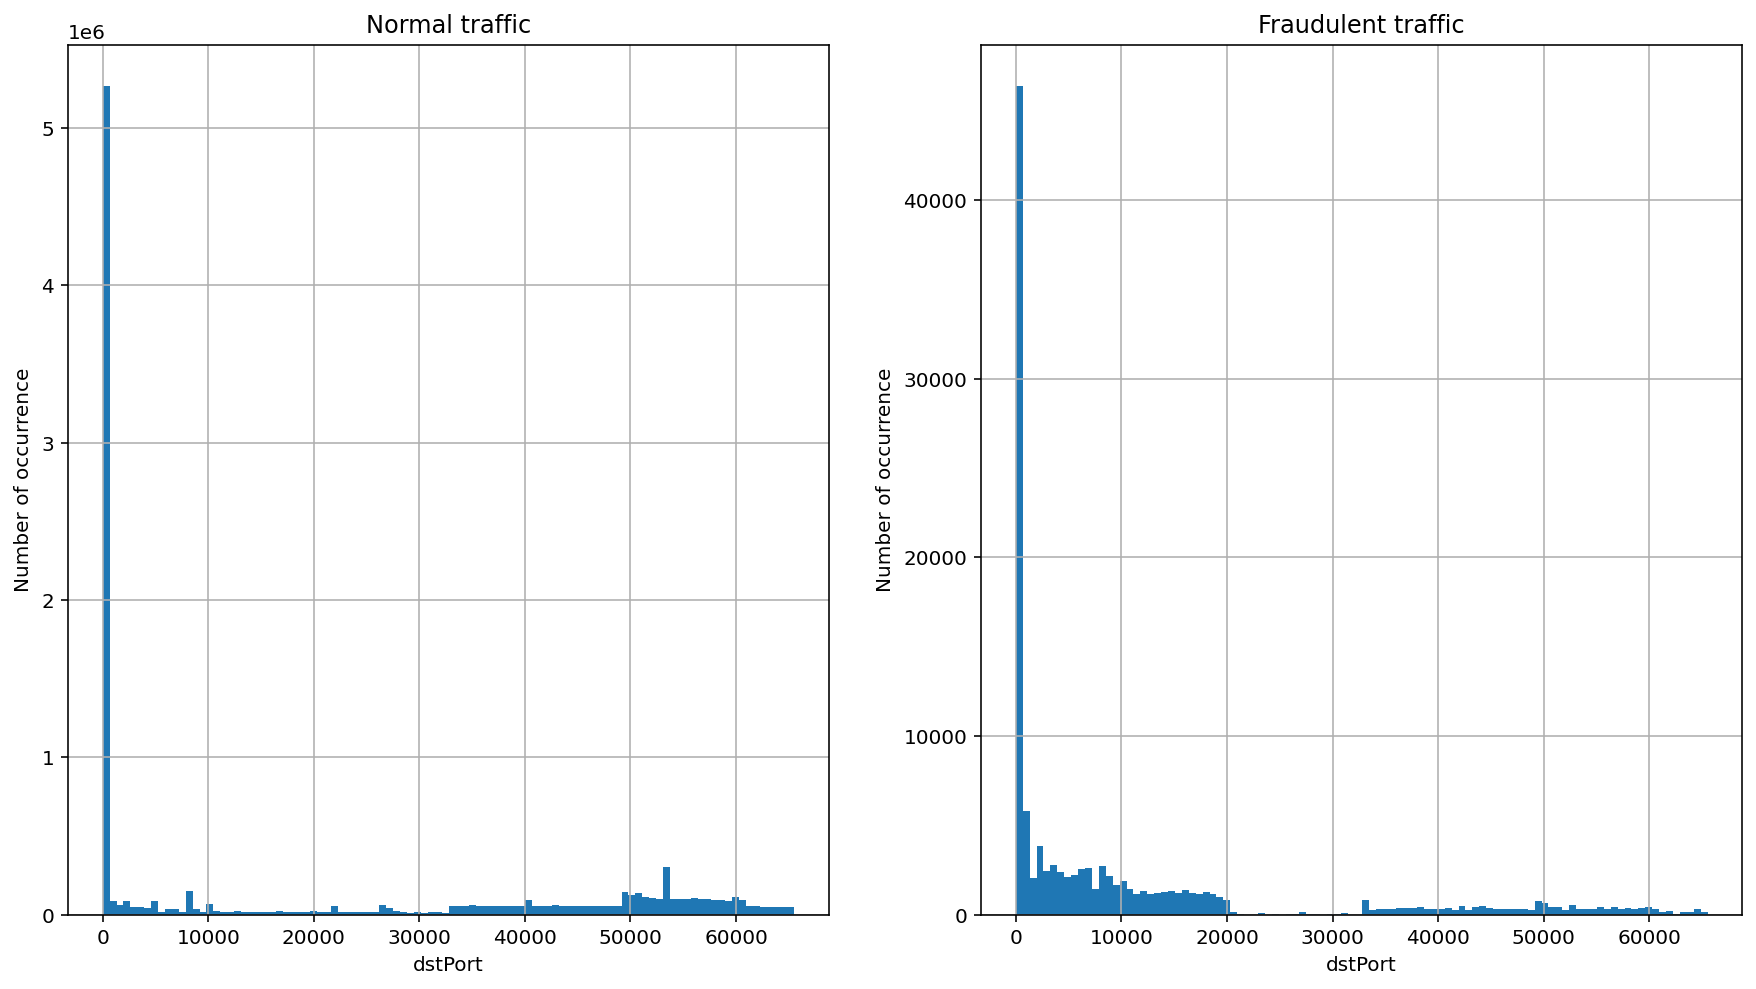

In [29]:
distribution_hist(normal_data, fraud_data, "dstPort", 100)

We can observe that there is almost no fraudulent traffic between destination ports 20000 and 32000. Also the majority of destination ports of fraudulent behaviors are below 20000.

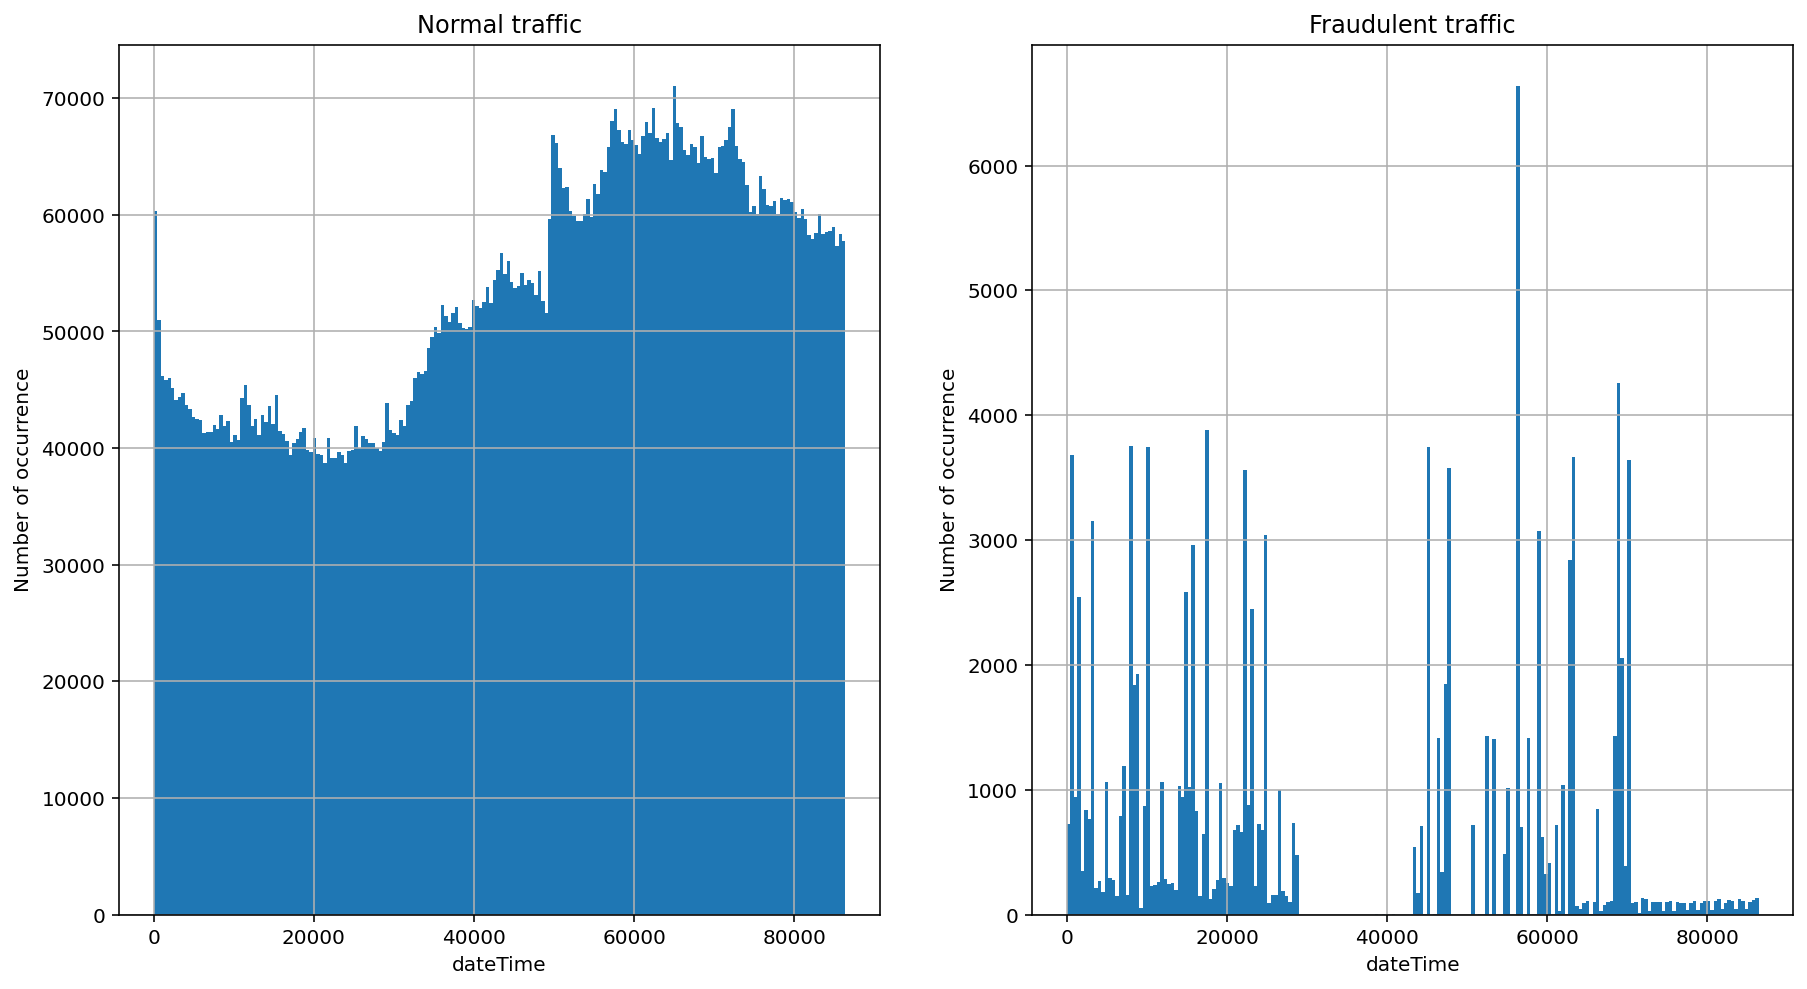

In [30]:
distribution_hist(normal_data, fraud_data, "dateTime", bins=200)

We can see that the time of fraudulent traffic if is very irregular.

## Data visualisation

We are going to see if we can find some information about the dataset's structure by visualising it.

In [31]:
dataset_visu = dataset.copy()

In [32]:
dataset_visu[["flag", "protocol"]] = OrdinalEncoder().fit_transform(dataset_visu[["flag", "protocol"]])

In [33]:
dataset_visu.head()

dateTime  duration  srcPort  dstPort  protocol  flag  tos  packets  bytes  \
0     49409       0.0       53    43192       6.0   8.0    0        1    214   
1     49409       0.0    59951       53       6.0   8.0    0        1    106   
2     49409       0.0    59993       53       6.0   8.0    0        1     60   
3     49409       0.0       53    60540       6.0   8.0    0        1    144   
4     49409       0.0    43790       53       6.0   8.0    0        1     59   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [34]:
def show3D_plot(data, x_axis_name, y_axis_name, z_axis_name):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    normal = data[data.label == 0]
    attack = data[data.label == 1]
    
    norm_normal = (normal[z_axis_name]-normal[z_axis_name].min())/(normal[z_axis_name].max()-normal[z_axis_name].min())
    norm_attack = (attack[z_axis_name]-attack[z_axis_name].min())/(attack[z_axis_name].max()-attack[z_axis_name].min())
    
    ax.scatter(normal[x_axis_name], normal[y_axis_name], norm_normal,
               color='green', alpha=0.03, marker='.', label="Normal traffic")
    ax.scatter(attack[x_axis_name], attack[y_axis_name], norm_attack,
               color='red', alpha=0.5, marker='.', label="Fraudulent traffic")
    
    ax.set_xlabel(x_axis_name)
    ax.set_ylabel(y_axis_name)
    ax.set_zlabel(z_axis_name)
    ax.legend()

    plt.show()

In [35]:
def show2D_plot(data, x_axis_name, y_axis_name):    
    normal = data[data.label == 0]
    attack = data[data.label == 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    ax1.scatter(normal[x_axis_name], normal[y_axis_name], color='green', alpha=0.03, marker='.')
    ax2.scatter(attack[x_axis_name], attack[y_axis_name], color='red', alpha=0.1, marker='.')
    
    normal_lim = ax1.get_ylim()
    fraud_lim = ax2.get_ylim()
    common_lim = (min(normal_lim[0], fraud_lim[0]), max(normal_lim[1], fraud_lim[1]))
    
    ax1.set_ylim(common_lim)
    ax1.set_xlabel(x_axis_name)
    ax1.set_ylabel(y_axis_name)
    ax1.set_title("Nomal traffic")
    
    ax2.set_title("Fraudulent traffic")
    ax2.set_ylim(common_lim)
    ax2.set_xlabel(x_axis_name)
    ax2.set_ylabel(y_axis_name)
    
    plt.show()

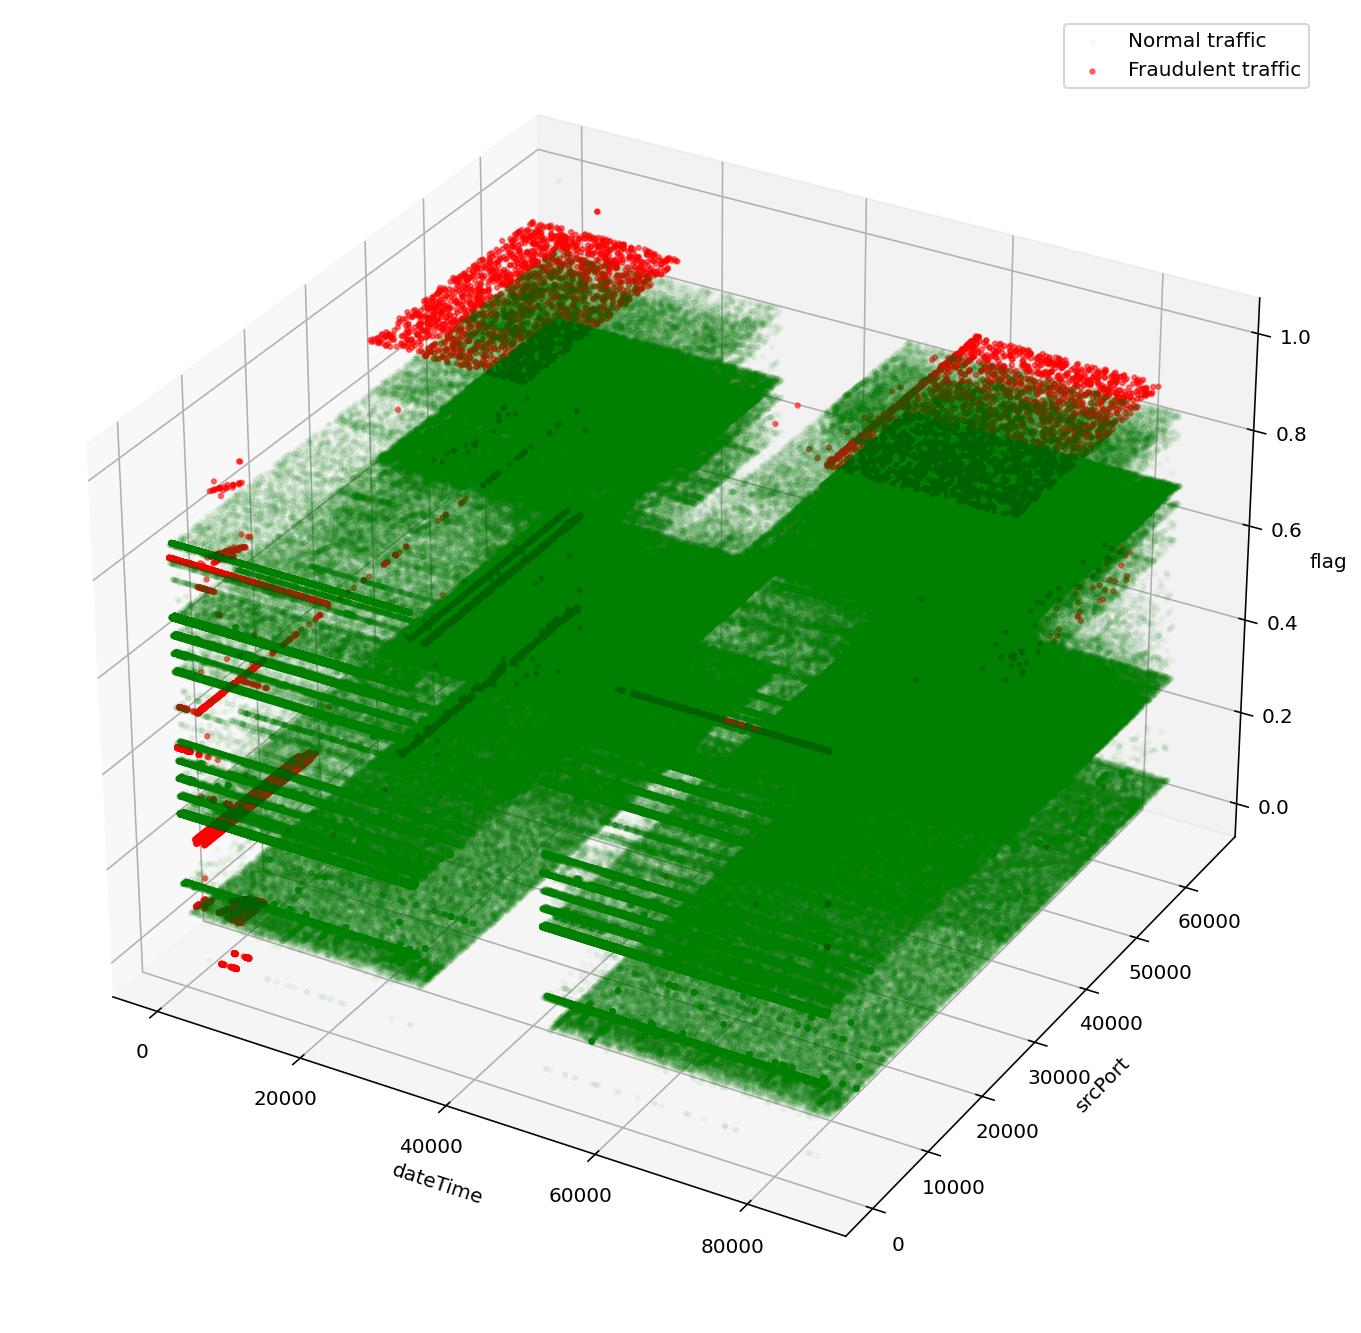

In [36]:
show3D_plot(dataset_visu[:2_000_000], "dateTime", "srcPort", "flag")

We can see a separation between fraudulent traffic and normal traffic

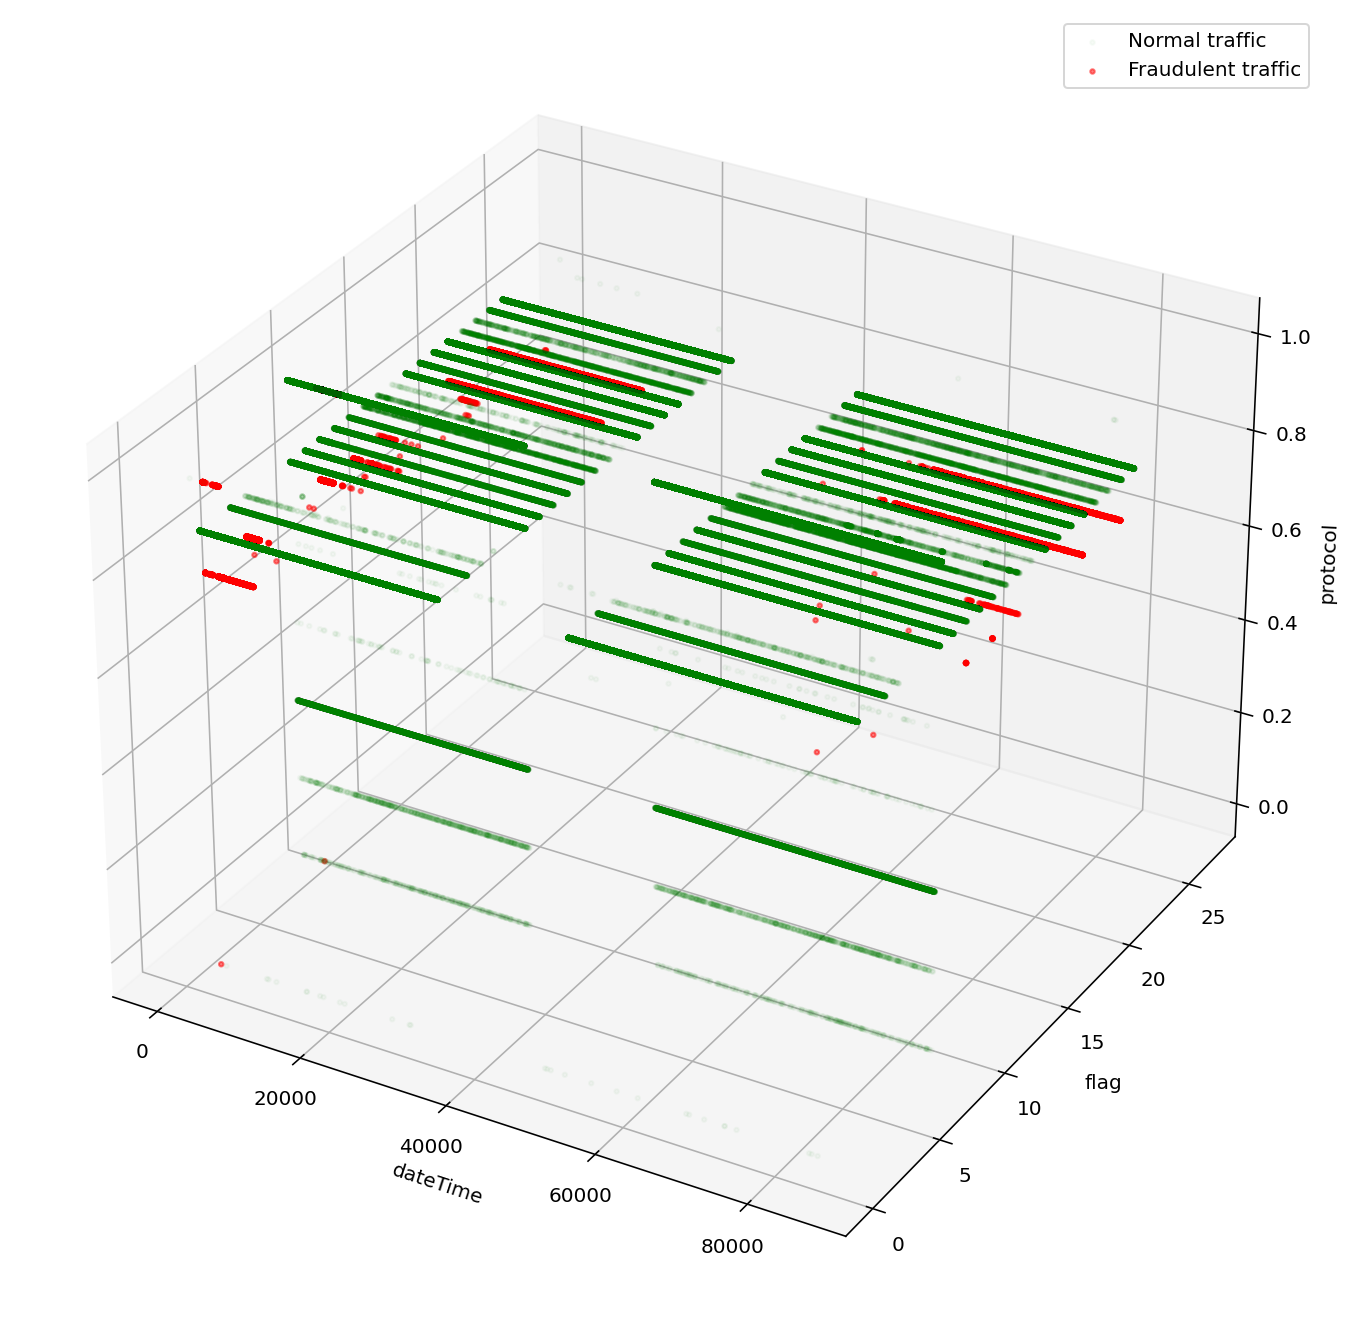

In [37]:
show3D_plot(dataset_visu[:2_000_000], "dateTime", "flag", "protocol")

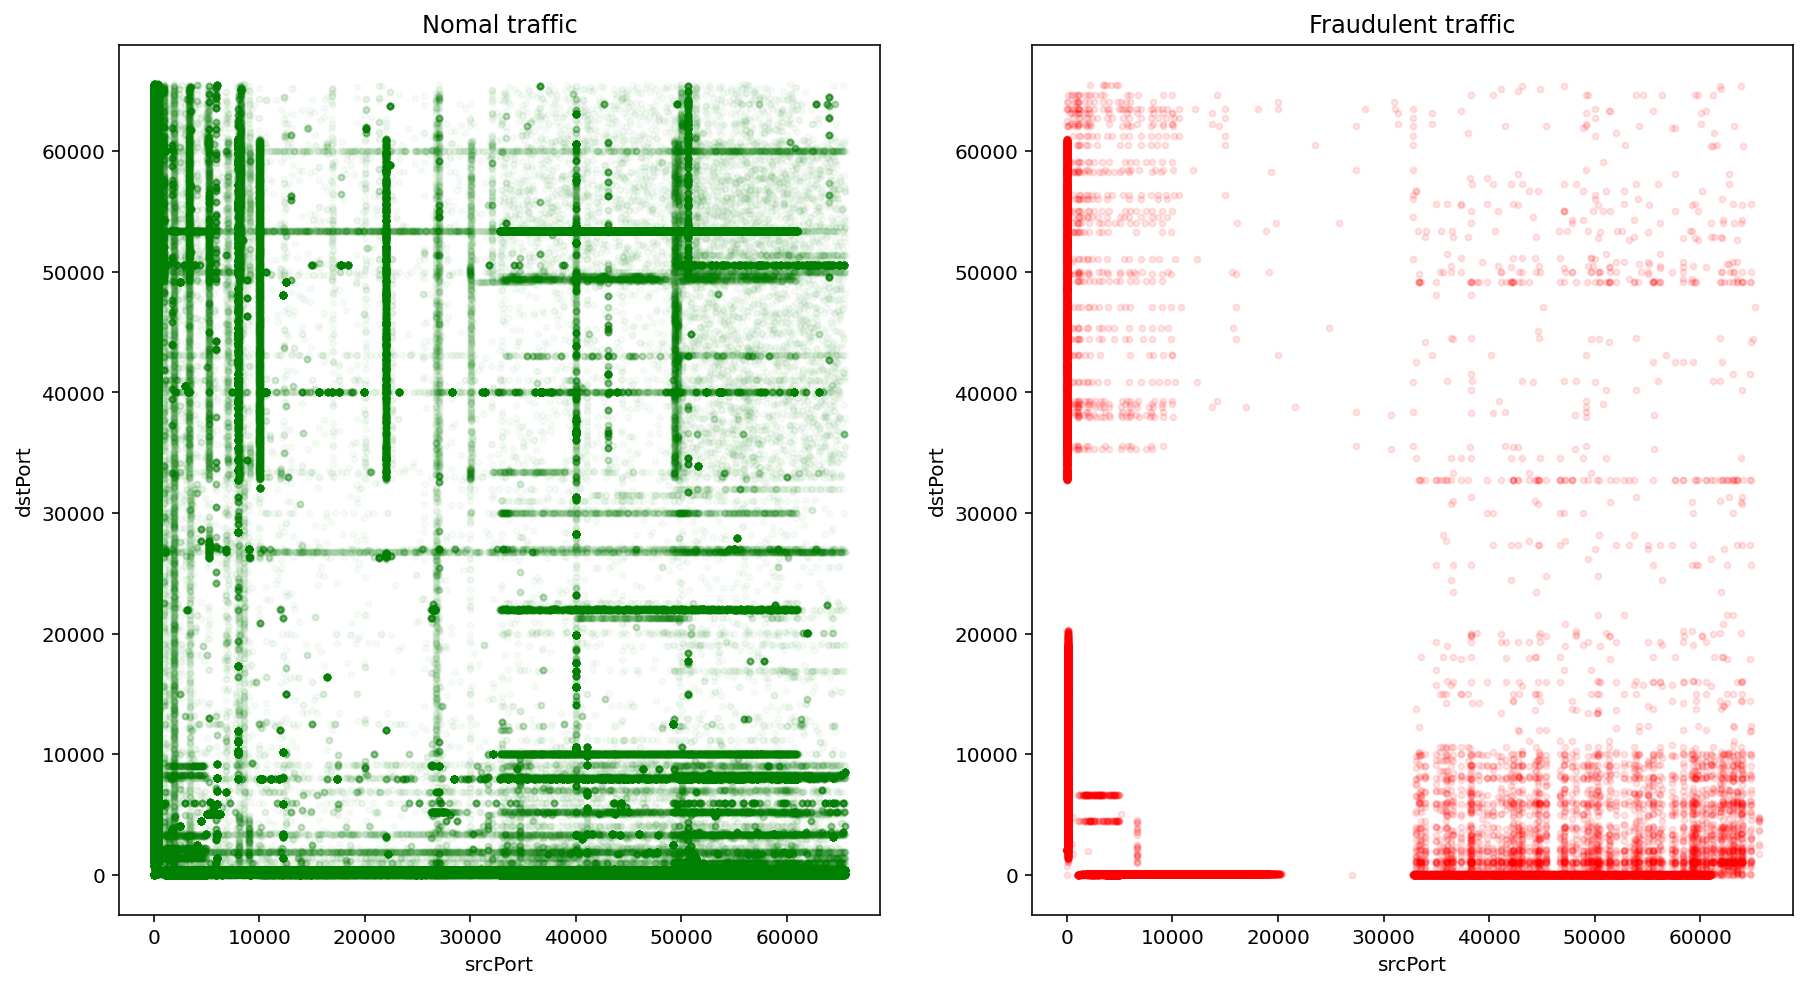

In [38]:
show2D_plot(dataset_visu[:2_000_000], "srcPort", "dstPort")

We can see that the normal traffic uses more combination of srcPort, dstPort.

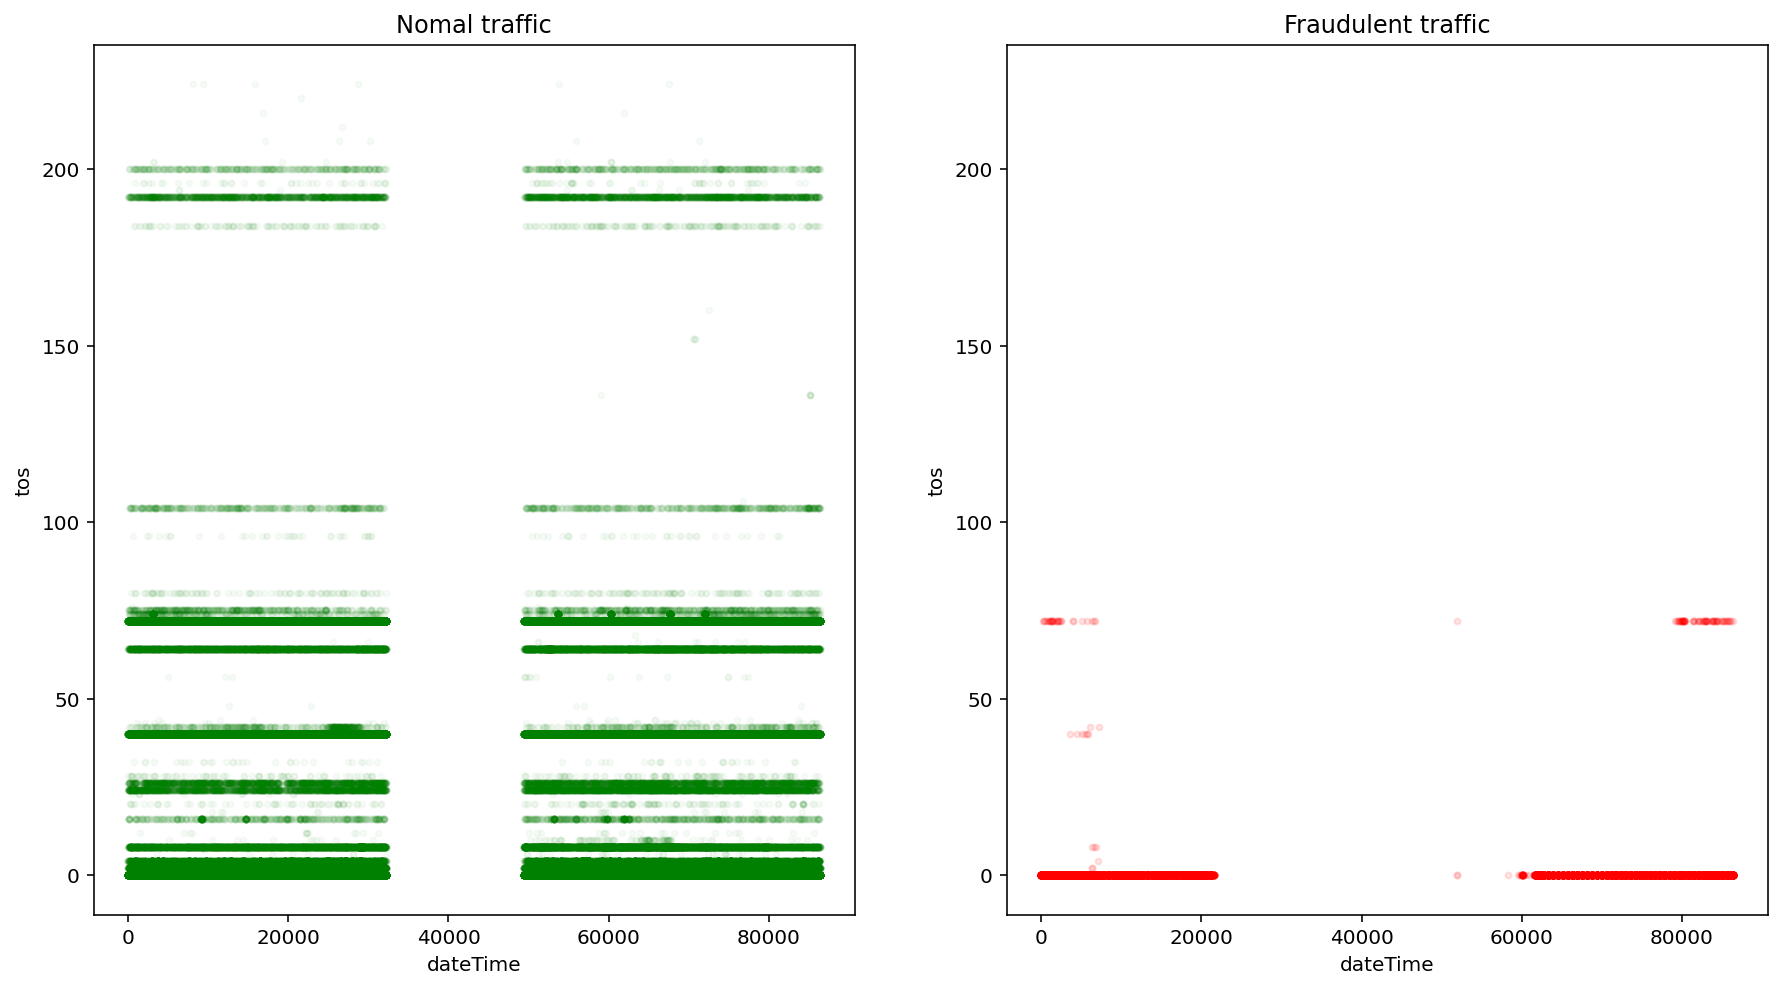

In [39]:
show2D_plot(dataset_visu[:2_000_000], "dateTime", "tos")

In [40]:
def correlation_matrix(dataset):
    corr_fraud = dataset[dataset.label == 1].corr()[:-1]
    corr_normal = dataset[dataset.label == 0].corr()[:-1]
 
    mask = np.triu(np.ones_like(corr_normal, dtype=bool))
    
    grid_kws = {"width_ratios": (.9, .9, .05), "wspace": .2}
    
    fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=(20, 8))
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    ylabels = list(corr_normal.columns[:-1])
    ylabels[0]=None
    ax1 = sns.heatmap(corr_normal, ax=ax1, vmin=-1, vmax=1, cmap=cmap,
                      square=False, mask=mask, cbar=False, annot=True,
                      xticklabels=corr_normal.columns[:-2], yticklabels=ylabels)
    ax1.set_title("Normal traffic")
    
    ax2 = sns.heatmap(corr_fraud, ax=ax2, vmin=-1, vmax=1, cmap=cmap, annot=True,
                      square=False, mask=mask, yticklabels=False, cbar_ax=cbar_ax,
                      cbar_kws={"orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]},
                      xticklabels=corr_fraud.columns[:-2])
    ax2.set_title("Fraudulent traffic")
    
    cbar_ax.set_yticklabels(cbar_ax.get_yticklabels())
    
    fig.suptitle("Correlation matrix")
    
    plt.show()

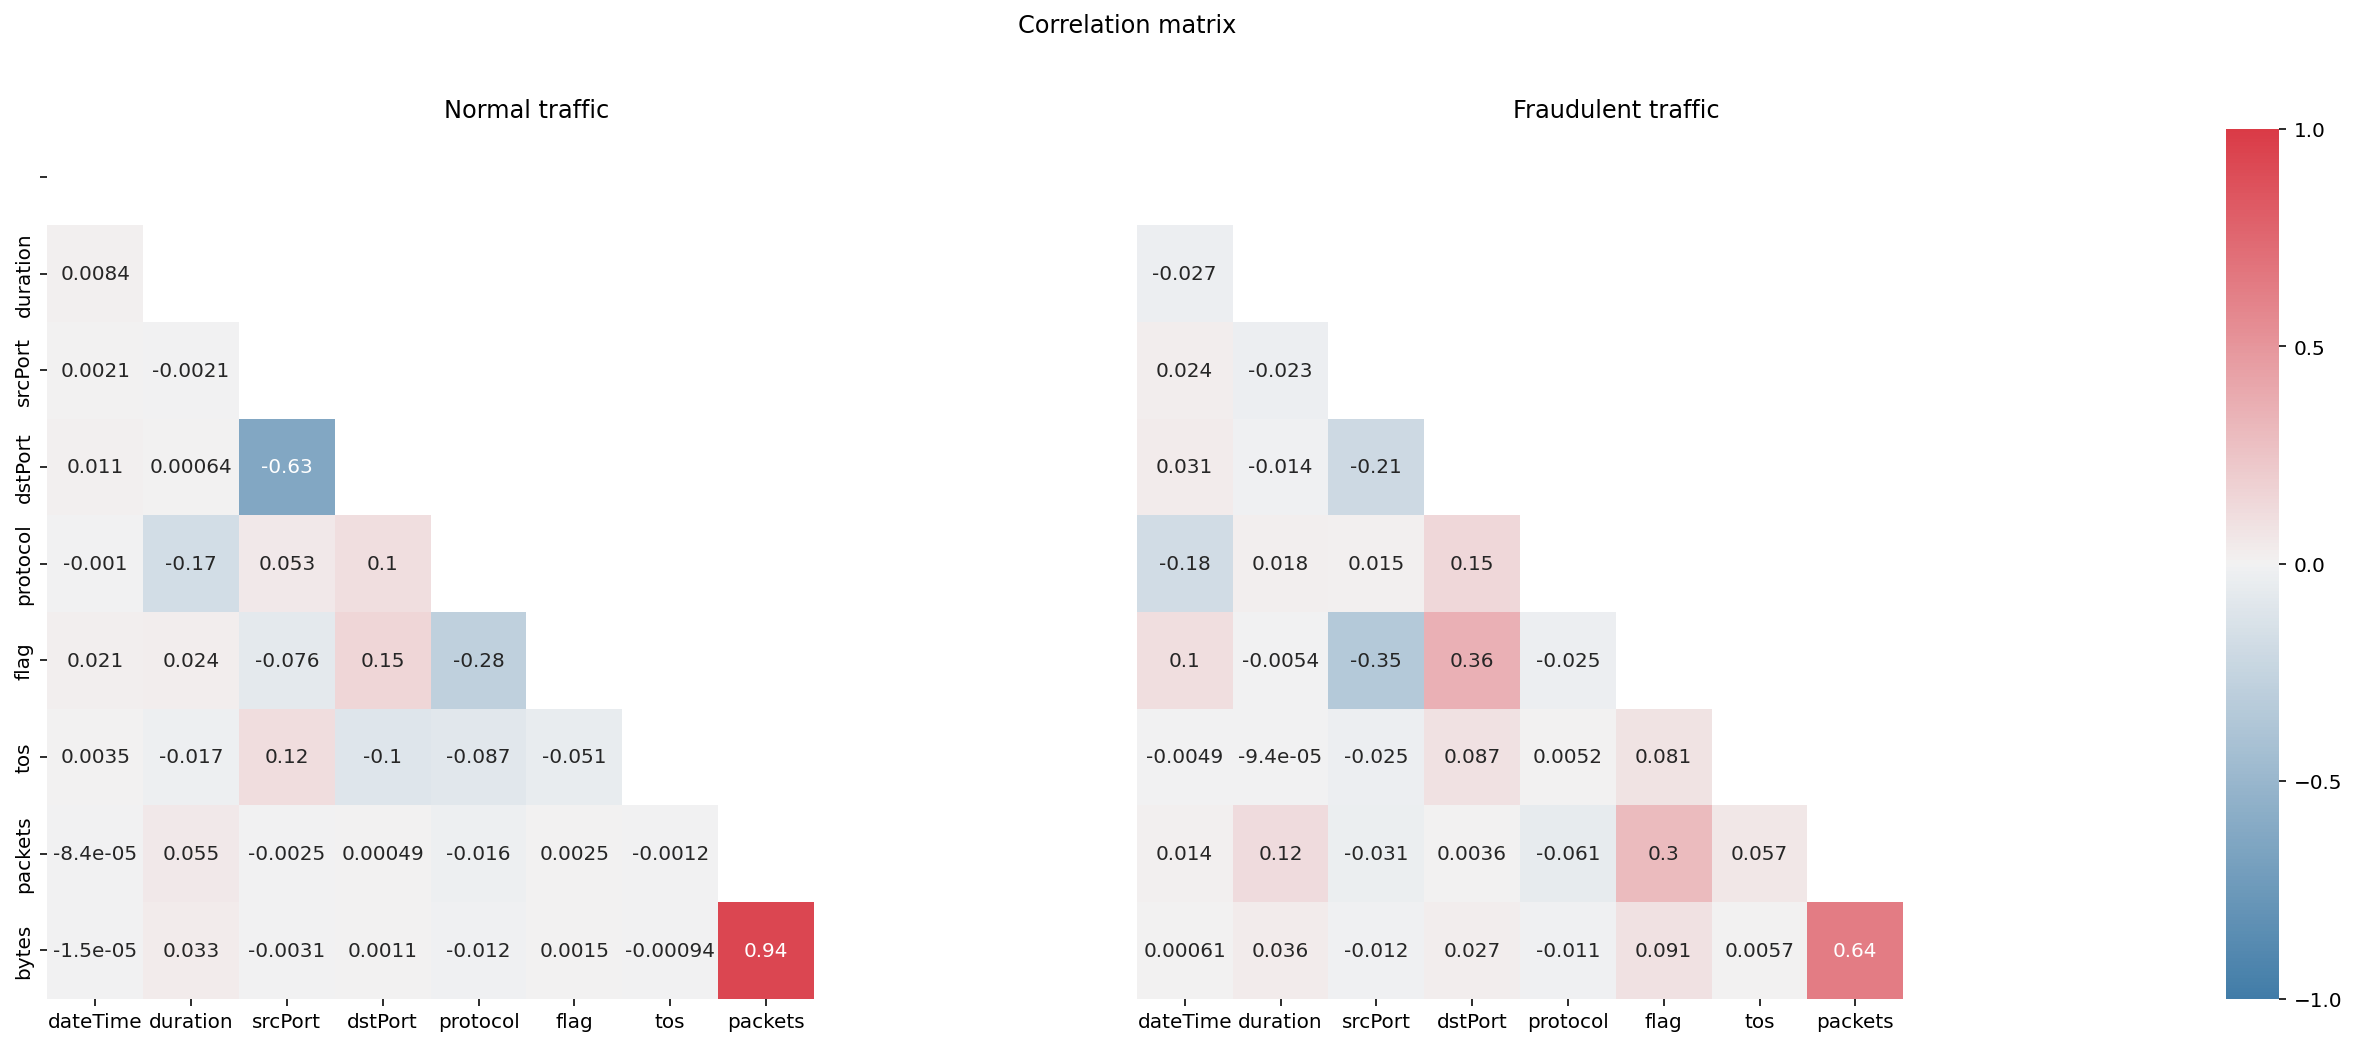

In [41]:
correlation_matrix(dataset_visu)

## Prepare data
We are going to prepare the data before training different ML models.

In this dataset there are two types of data : 
- numerical: *dateTime, duration, packets, bytes and tos*
- categorical: *srcPort, dstPort, protocol and flag*

### Feature engineering 

In [42]:
def create_range_port(val):
    if val <= 500:
        return "a"
    
    if val <= 1000:
        return "b"
    
    if val <= 2000:
        return "c"
    
    if val <= 3000:
        return "e"
    
    if val <= 6500:
        return "f"
    
    if val <= 20_000:
        return "g"
    
    if val <= 32_000:
        return "h"
    
    
    return "i"

In [43]:
X_numerical = dataset[["dateTime", "duration", "packets", "bytes", "tos"]].copy()
X_numcat = dataset[["dstPort", "srcPort"]].copy()
X_categorical = dataset[["protocol", "flag"]].copy()
Y = dataset.label.copy()

### Prepare numerical data

We are going to normalize the numerical data.

In [44]:
X_num_norm = pd.DataFrame(Normalizer().fit_transform(X_numerical), columns=X_numerical.columns)

In [45]:
X_num_norm.head()

dateTime  duration  packets     bytes  tos
0  0.999991       0.0  0.00002  0.004331  0.0
1  0.999998       0.0  0.00002  0.002145  0.0
2  0.999999       0.0  0.00002  0.001214  0.0
3  0.999996       0.0  0.00002  0.002914  0.0
4  0.999999       0.0  0.00002  0.001194  0.0

### Prepare categorical data

We are going to encode categorical data

There are many combination of the variables *srcPort, dstPort*, so we will just encode the values without using the one hot encoder.

In [46]:
X_numcat_cat = X_numcat.srcPort.apply(create_range_port).to_frame()
X_numcat_cat['dstPort'] = X_numcat.dstPort.apply(create_range_port)
X_numcat_onehot = pd.get_dummies(X_numcat_cat)

In [47]:
X_numcat_onehot.head()

srcPort_a  srcPort_b  srcPort_c  srcPort_e  srcPort_f  srcPort_g  \
0          1          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          0          0          0          0          0   

   srcPort_h  srcPort_i  dstPort_a  dstPort_b  dstPort_c  dstPort_e  \
0          0          0          0          0          0          0   
1          0          1          1          0          0          0   
2          0          1          1          0          0          0   
3          0          0          0          0          0          0   
4          0          1          1          0          0          0   

   dstPort_f  dstPort_g  dstPort_h  dstPort_i  
0          0          0          0          1  
1          0          0          0          0  
2          0          0          0          0  
3          0          0          0          1  
4          0          0          0          0

For the variables *protocol and flag* we will use a one hot encoding

In [48]:
X_cat_onehot = pd.get_dummies(X_categorical)

In [49]:
X_cat_onehot.head()

protocol_ESP  protocol_GRE  protocol_ICMP  protocol_IPIP  protocol_IPv6  \
0             0             0              0              0              0   
1             0             0              0              0              0   
2             0             0              0              0              0   
3             0             0              0              0              0   
4             0             0              0              0              0   

   protocol_TCP  protocol_UDP  flag_......  flag_.....F  flag_....S.  \
0             0             1            0            0            0   
1             0             1            0            0            0   
2             0             1            0            0            0   
3             0             1            0            0            0   
4             0             1            0            0            0   

   flag_....SF  flag_...R..  flag_...RS.  flag_..P.S.  flag_..PR.F  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   flag_.A....  flag_.A...F  flag_.A..S.  flag_.A..SF  flag_.A.R..  \
0            1            0            0            0            0   
1            1            0            0            0            0   
2            1            0            0            0            0   
3            1            0            0            0            0   
4            1            0            0            0            0   

   flag_.A.R.F  flag_.A.RS.  flag_.A.RSF  flag_.AP...  flag_.AP..F  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   flag_.AP.S.  flag_.AP.SF  flag_.APR..  flag_.APR.F  flag_.APRS.  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   flag_.APRSF  flag_U.P..F  flag_U.P.S.  flag_UA...F  flag_UA..SF  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   flag_UAP.S.  flag_UAP.SF  
0            0            0  
1            0            0  
2            0            0  
3            0            0  
4            0            0

## Machine Learning models

In [50]:
def plot_metrics(y_pred, y_true):
    print("################### Metrics ###################\n")
    
    nb_values = len(y_true)
    nb_attacks = y_true.sum()
    nb_normal = nb_values - nb_attacks
    
    print(f"Number of values: {nb_values}")
    print(f"Number of non fraudulent values: {nb_normal} | {round(nb_normal / nb_values * 100, 5)}% of the data")
    print(f"Number of fraudulent values: {nb_attacks} | {round(nb_attacks / nb_values * 100, 5)}% of the data")
    
    print("")
    
    correct = (y_pred == y_true).sum()
    correct_normal = np.where((y_pred == 0) & (y_true == 0), 1, 0).sum()
    correct_attack = np.where((y_pred == 1) & (y_true == 1), 1, 0).sum()
    false_negative = np.where((y_pred == 1) & (y_true == 0), 1, 0).sum()
    false_positive = np.where((y_pred == 0) & (y_true == 1), 1, 0).sum()
    
    print(f"Number of correct classification: {correct} | Accuracy: {round(correct / nb_values * 100, 5)}%")
    
    print(f"Number of non fraudulent values detected: {correct_normal}\n"
          f"| Percentage of correct classification {round(correct_normal / nb_values * 100, 5)}% (True positive in total number of values)\n"
          f"| Accuracy of the class: {round(correct_normal / nb_normal * 100, 5)}% (True positive in non fraudulent values count)\n")
    
    print(f"Number of fraudulent values detected: {correct_attack}\n"
          f"| Percentage of correct classification {round(correct_attack / nb_values * 100, 5)}% (True negative in total number of values)\n"
          f"| Accuracy of the class: {round(correct_attack / nb_attacks * 100, 5)}% (True negative in fraudulent values count)\n")
    
    print(f"Number of false negative: {false_negative}\n"
          f"| Percentage of false negative: {round(false_negative / nb_values * 100, 5)}% (false negative in total number of values)\n")
    
    print(f"Number of false positive: {false_positive}\n"
          f"| Percentage of false posivive: {round(false_positive / nb_values * 100, 5)}% (false positive in total number of values)")
    
    print("")
    
    print(f"Balanced accuracy score: {round(balanced_accuracy_score(y_true, y_pred) * 100, 5)}%")
    print(f"Precision: {round(precision_score(y_true, y_pred), 5)}")
    print(f"Recall: {round(recall_score(y_true, y_pred), 5)}")
    print(f"R2: {round(r2_score(y_true, y_pred), 5)}")
    print(f"F1 score: {round(f1_score(y_true, y_pred), 5)}")
    
    print("###############################################")

In [51]:
def create_aucroc(classifier, X_test, Y_test):
    Y_test = Y_test.replace(1, -1).replace(0, 1)
    y_pred_iso = classifier.decision_function(X_test)
    fpr, tpr, threshold = roc_curve(Y_test, y_pred_iso)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Isolation Forest

In [52]:
X_feature_if = pd.concat([X_num_norm, X_cat_onehot, X_numcat_onehot], axis=1)
X_train_if, X_test_if, Y_train_if, Y_test_if = train_test_split(X_feature_if, Y, test_size=0.2, random_state=3)

In [53]:
%%time
model_if = IsolationForest(random_state=3, contamination=0.02, n_jobs=6)
model_if = model_if.fit(X_train_if[:300_000])

CPU times: user 21.5 s, sys: 8.62 s, total: 30.1 s
Wall time: 15.7 s


In [54]:
y_pred_if_train = np.where(model_if.predict(X_train_if[:300_000]) == -1, 1, 0)
plot_metrics(y_pred_if_train, Y_train_if[:300_000])

################### Metrics ###################

Number of values: 300000
Number of non fraudulent values: 296610 | 98.87% of the data
Number of fraudulent values: 3390 | 1.13% of the data

Number of correct classification: 290663 | Accuracy: 96.88767%
Number of non fraudulent values detected: 290638
| Percentage of correct classification 96.87933% (True positive in total number of values)
| Accuracy of the class: 97.98658% (True positive in non fraudulent values count)

Number of fraudulent values detected: 25
| Percentage of correct classification 0.00833% (True negative in total number of values)
| Accuracy of the class: 0.73746% (True negative in fraudulent values count)

Number of false negative: 5972
| Percentage of false negative: 1.99067% (false negative in total number of values)

Number of false positive: 3365
| Percentage of false posivive: 1.12167% (false positive in total number of values)

Balanced accuracy score: 49.36202%
Precision: 0.00417
Recall: 0.00737
R2: -1.78576


In [55]:
y_pred_if_test = np.where(model_if.predict(X_test_if[:200_000]) == -1, 1, 0)
plot_metrics(y_pred_if_test, Y_test_if[:200_000])

################### Metrics ###################

Number of values: 200000
Number of non fraudulent values: 197792 | 98.896% of the data
Number of fraudulent values: 2208 | 1.104% of the data

Number of correct classification: 193836 | Accuracy: 96.918%
Number of non fraudulent values detected: 193817
| Percentage of correct classification 96.9085% (True positive in total number of values)
| Accuracy of the class: 97.99031% (True positive in non fraudulent values count)

Number of fraudulent values detected: 19
| Percentage of correct classification 0.0095% (True negative in total number of values)
| Accuracy of the class: 0.86051% (True negative in fraudulent values count)

Number of false negative: 3975
| Percentage of false negative: 1.9875% (false negative in total number of values)

Number of false positive: 2189
| Percentage of false posivive: 1.0945% (false positive in total number of values)

Balanced accuracy score: 49.42541%
Precision: 0.00476
Recall: 0.00861
R2: -1.82283
F1 s

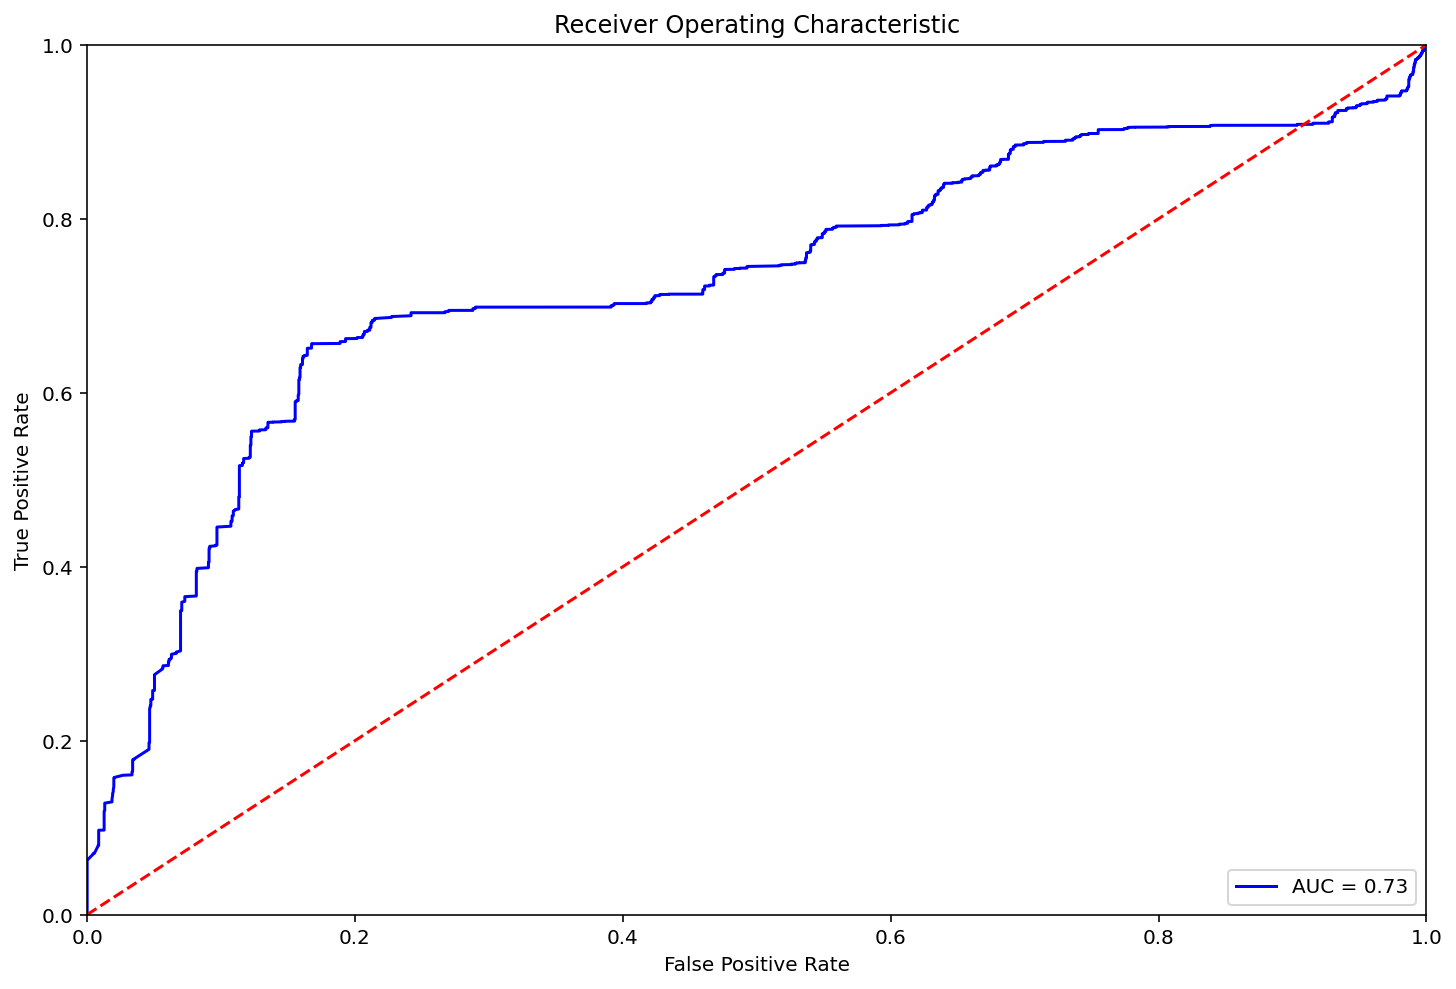

In [56]:
create_aucroc(model_if, X_test_if[:200_000], Y_test_if[:200_000])

We can see with this model that we cannot classify correctly the fraudulent traffic.

### One class SVM

In [57]:
X_feature_svm = pd.concat([X_num_norm, X_cat_onehot, X_numcat_onehot], axis=1)
X_train_svm, X_test_svm, Y_train_svm, Y_test_svm = train_test_split(X_feature_svm, Y, test_size=0.2, random_state=3)

In [58]:
%%time
model_svm = OneClassSVM(kernel="linear")
model_svm = model_svm.fit(X_train_svm[:20_000])

CPU times: user 21.3 s, sys: 206 ms, total: 21.5 s
Wall time: 21.6 s


In [59]:
y_pred_svm_train = np.where(model_svm.predict(X_train_svm[:20_000]) == -1, 1, 0)
plot_metrics(y_pred_svm_train, Y_train_svm[:20_000])

################### Metrics ###################

Number of values: 20000
Number of non fraudulent values: 19752 | 98.76% of the data
Number of fraudulent values: 248 | 1.24% of the data

Number of correct classification: 10207 | Accuracy: 51.035%
Number of non fraudulent values detected: 9979
| Percentage of correct classification 49.895% (True positive in total number of values)
| Accuracy of the class: 50.52147% (True positive in non fraudulent values count)

Number of fraudulent values detected: 228
| Percentage of correct classification 1.14% (True negative in total number of values)
| Accuracy of the class: 91.93548% (True negative in fraudulent values count)

Number of false negative: 9773
| Percentage of false negative: 48.865% (false negative in total number of values)

Number of false positive: 20
| Percentage of false posivive: 0.1% (false positive in total number of values)

Balanced accuracy score: 71.22848%
Precision: 0.0228
Recall: 0.91935
R2: -38.9837
F1 score: 0.04449
#

In [60]:
y_pred_svm_test = np.where(model_svm.predict(X_test_svm[:15_000]) == -1, 1, 0)
plot_metrics(y_pred_svm_test, Y_test_svm[:15_000])

################### Metrics ###################

Number of values: 15000
Number of non fraudulent values: 14836 | 98.90667% of the data
Number of fraudulent values: 164 | 1.09333% of the data

Number of correct classification: 7793 | Accuracy: 51.95333%
Number of non fraudulent values detected: 7652
| Percentage of correct classification 51.01333% (True positive in total number of values)
| Accuracy of the class: 51.57724% (True positive in non fraudulent values count)

Number of fraudulent values detected: 141
| Percentage of correct classification 0.94% (True negative in total number of values)
| Accuracy of the class: 85.97561% (True negative in fraudulent values count)

Number of false negative: 7184
| Percentage of false negative: 47.89333% (false negative in total number of values)

Number of false positive: 23
| Percentage of false posivive: 0.15333% (false positive in total number of values)

Balanced accuracy score: 68.77643%
Precision: 0.01925
Recall: 0.85976
R2: -43.4309
F1 

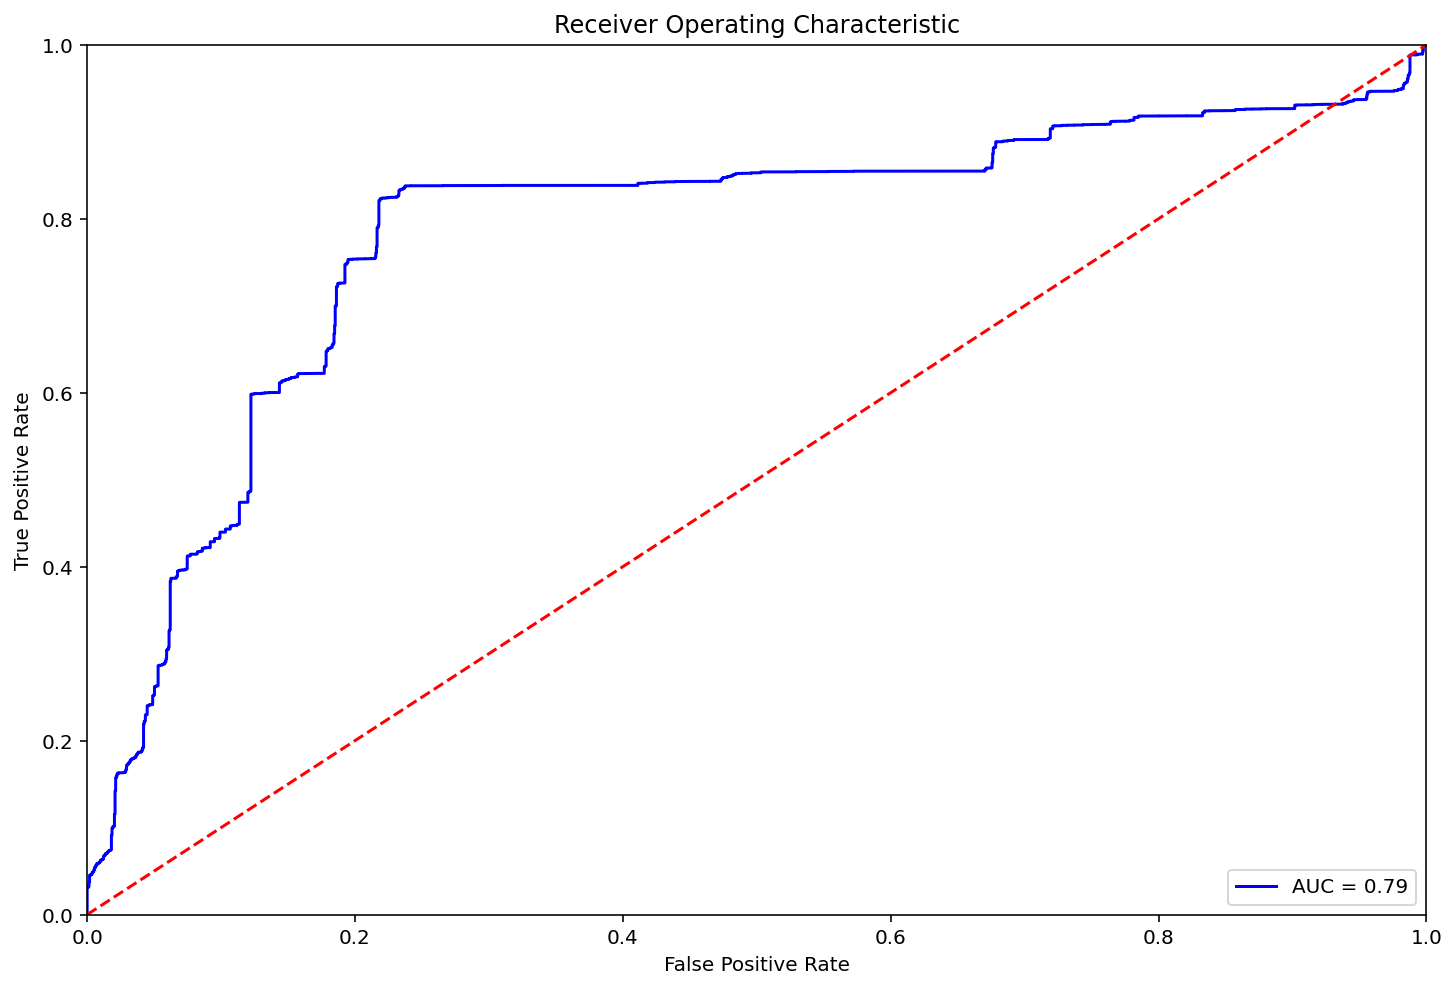

In [61]:
create_aucroc(model_svm, X_test_svm[:200_000], Y_test_svm[:200_000])

We can see that the one class SVM has better results to classify fraudulent traffic compare to the Isolation Forest. However the classification
of the non fraudulent traffic is worst.

### XGBoost

In [62]:
X_feature_xgboost = pd.concat([X_numerical, X_cat_onehot, X_numcat], axis=1)
X_train_xgboost, X_test_xgboost, Y_train_xgboost, Y_test_xgboost = train_test_split(X_feature_xgboost[:2_000_000],
                                                                                    Y[:2_000_000], test_size=0.2, random_state=3)

In [63]:
evalset = [(X_train_xgboost, Y_train_xgboost), (X_test_xgboost, Y_test_xgboost)]
weight = (Y == 0).sum() / (1.0 * (Y == 1).sum())

In [64]:
clf = xgb.XGBClassifier(max_depth=6, scale_pos_weight=weight, n_estimators=100,
                        n_jobs=6, verbosity=0, objective="binary:logistic").fit(X_train_xgboost, Y_train_xgboost, eval_set=evalset)

/usr/local/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.45139	validation_1-logloss:0.45162
[1]	validation_0-logloss:0.31873	validation_1-logloss:0.31858
[2]	validation_0-logloss:0.23417	validation_1-logloss:0.23457
[3]	validation_0-logloss:0.17880	validation_1-logloss:0.17859
[4]	validation_0-logloss:0.13551	validation_1-logloss:0.13538
[5]	validation_0-logloss:0.10260	validation_1-logloss:0.10262
[6]	validation_0-logloss:0.07968	validation_1-logloss:0.07980
[7]	validation_0-logloss:0.06113	validation_1-logloss:0.06106
[8]	validation_0-logloss:0.04909	validation_1-logloss:0.04911
[9]	validation_0-logloss:0.04065	validation_1-logloss:0.04061
[10]	validation_0-logloss:0.03408	validation_1-logloss:0.03400
[11]	validation_0-logloss:0.02869	validation_1-logloss:0.02871
[12]	validation_0-logloss:0.02351	validation_1-logloss:0.02355
[13]	validation_0-logloss:0.02039	validation_1-logloss:0.02047
[14]	validation_0-logloss:0.01811	validation_1-logloss:0.01829
[15]	validation_0-logloss:0.01624	validation_1-logloss:0.01629
[1

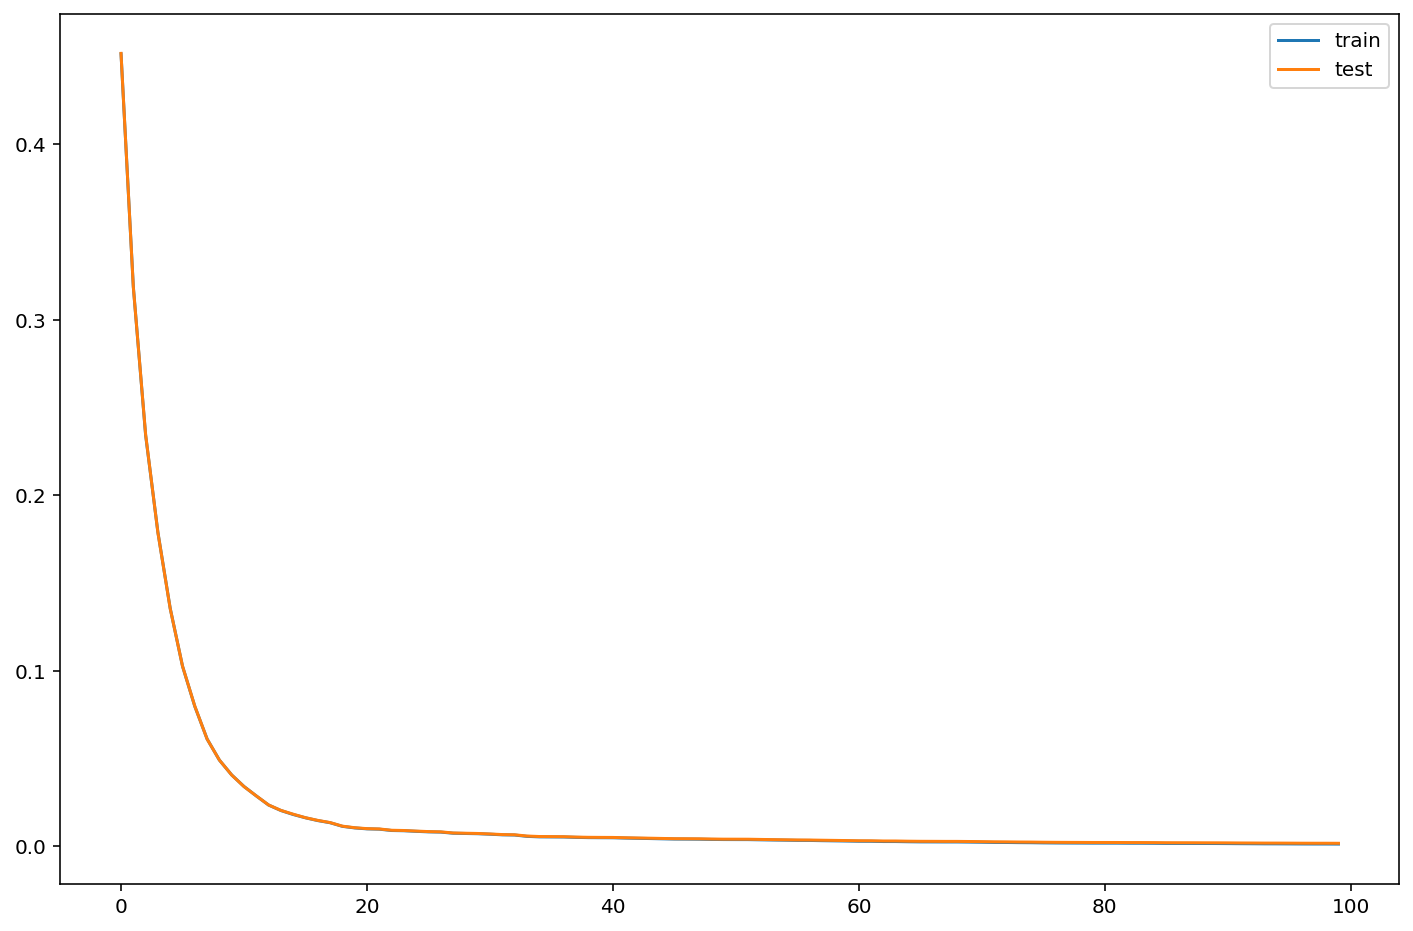

In [65]:
results = clf.evals_result()
plt.figure(figsize=(12, 8))
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

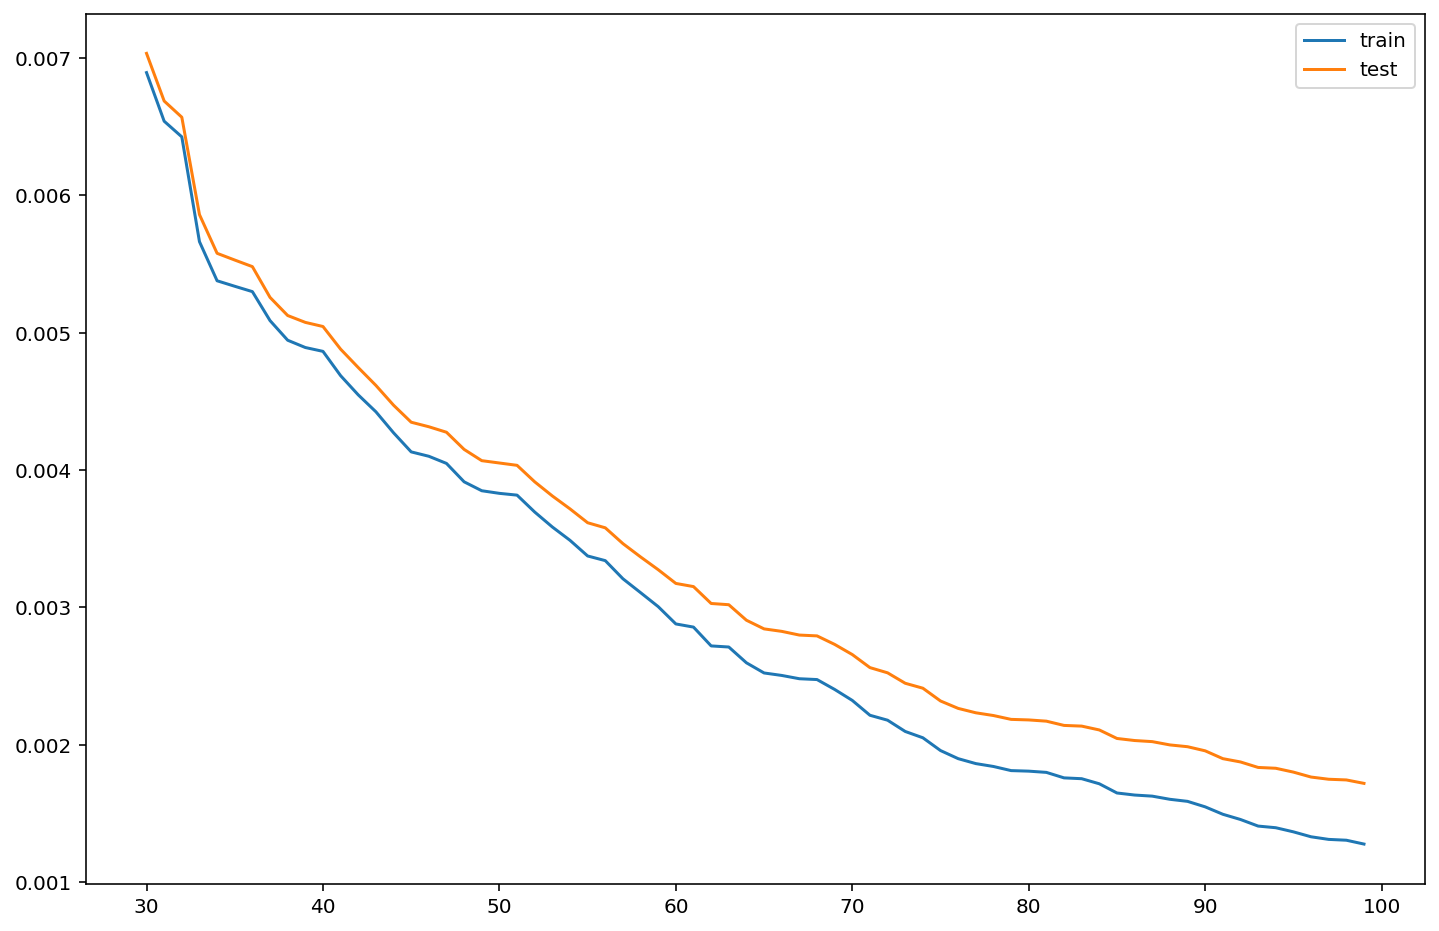

In [78]:
results = clf.evals_result()
plt.figure(figsize=(12, 8))
plt.plot(range(30, 100), results['validation_0']['logloss'][30:], label='train')
plt.plot(range(30, 100), results['validation_1']['logloss'][30:], label='test')
plt.legend()
plt.show()

In [66]:
y_pred_xgboost_test = clf.predict_proba(X_test_xgboost)
y_pred_xgboost_train = clf.predict_proba(X_train_xgboost)

In [67]:
plot_metrics(np.where(y_pred_xgboost_train[:, 1] < 0.5, 0, 1), Y_train_xgboost)

################### Metrics ###################

Number of values: 1600000
Number of non fraudulent values: 1579961 | 98.74756% of the data
Number of fraudulent values: 20039 | 1.25244% of the data

Number of correct classification: 1599534 | Accuracy: 99.97088%
Number of non fraudulent values detected: 1579495
| Percentage of correct classification 98.71844% (True positive in total number of values)
| Accuracy of the class: 99.97051% (True positive in non fraudulent values count)

Number of fraudulent values detected: 20039
| Percentage of correct classification 1.25244% (True negative in total number of values)
| Accuracy of the class: 100.0% (True negative in fraudulent values count)

Number of false negative: 466
| Percentage of false negative: 0.02912% (false negative in total number of values)

Number of false positive: 0
| Percentage of false posivive: 0.0% (false positive in total number of values)

Balanced accuracy score: 99.98525%
Precision: 0.97727
Recall: 1.0
R2: 0.97645
F

In [68]:
plot_metrics(np.where(y_pred_xgboost_test[:, 1] < 0.5, 0, 1), Y_test_xgboost)

################### Metrics ###################

Number of values: 400000
Number of non fraudulent values: 394957 | 98.73925% of the data
Number of fraudulent values: 5043 | 1.26075% of the data

Number of correct classification: 399821 | Accuracy: 99.95525%
Number of non fraudulent values detected: 394803
| Percentage of correct classification 98.70075% (True positive in total number of values)
| Accuracy of the class: 99.96101% (True positive in non fraudulent values count)

Number of fraudulent values detected: 5018
| Percentage of correct classification 1.2545% (True negative in total number of values)
| Accuracy of the class: 99.50426% (True negative in fraudulent values count)

Number of false negative: 154
| Percentage of false negative: 0.0385% (false negative in total number of values)

Number of false positive: 25
| Percentage of false posivive: 0.00625% (false positive in total number of values)

Balanced accuracy score: 99.73264%
Precision: 0.97022
Recall: 0.99504
R2: 0.964

In [69]:
def plotXGBoost(clf):
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(111)
    
    ax = xgb.plot_importance(clf, height=1, importance_type='gain', ax=ax)
    
    plt.plot()

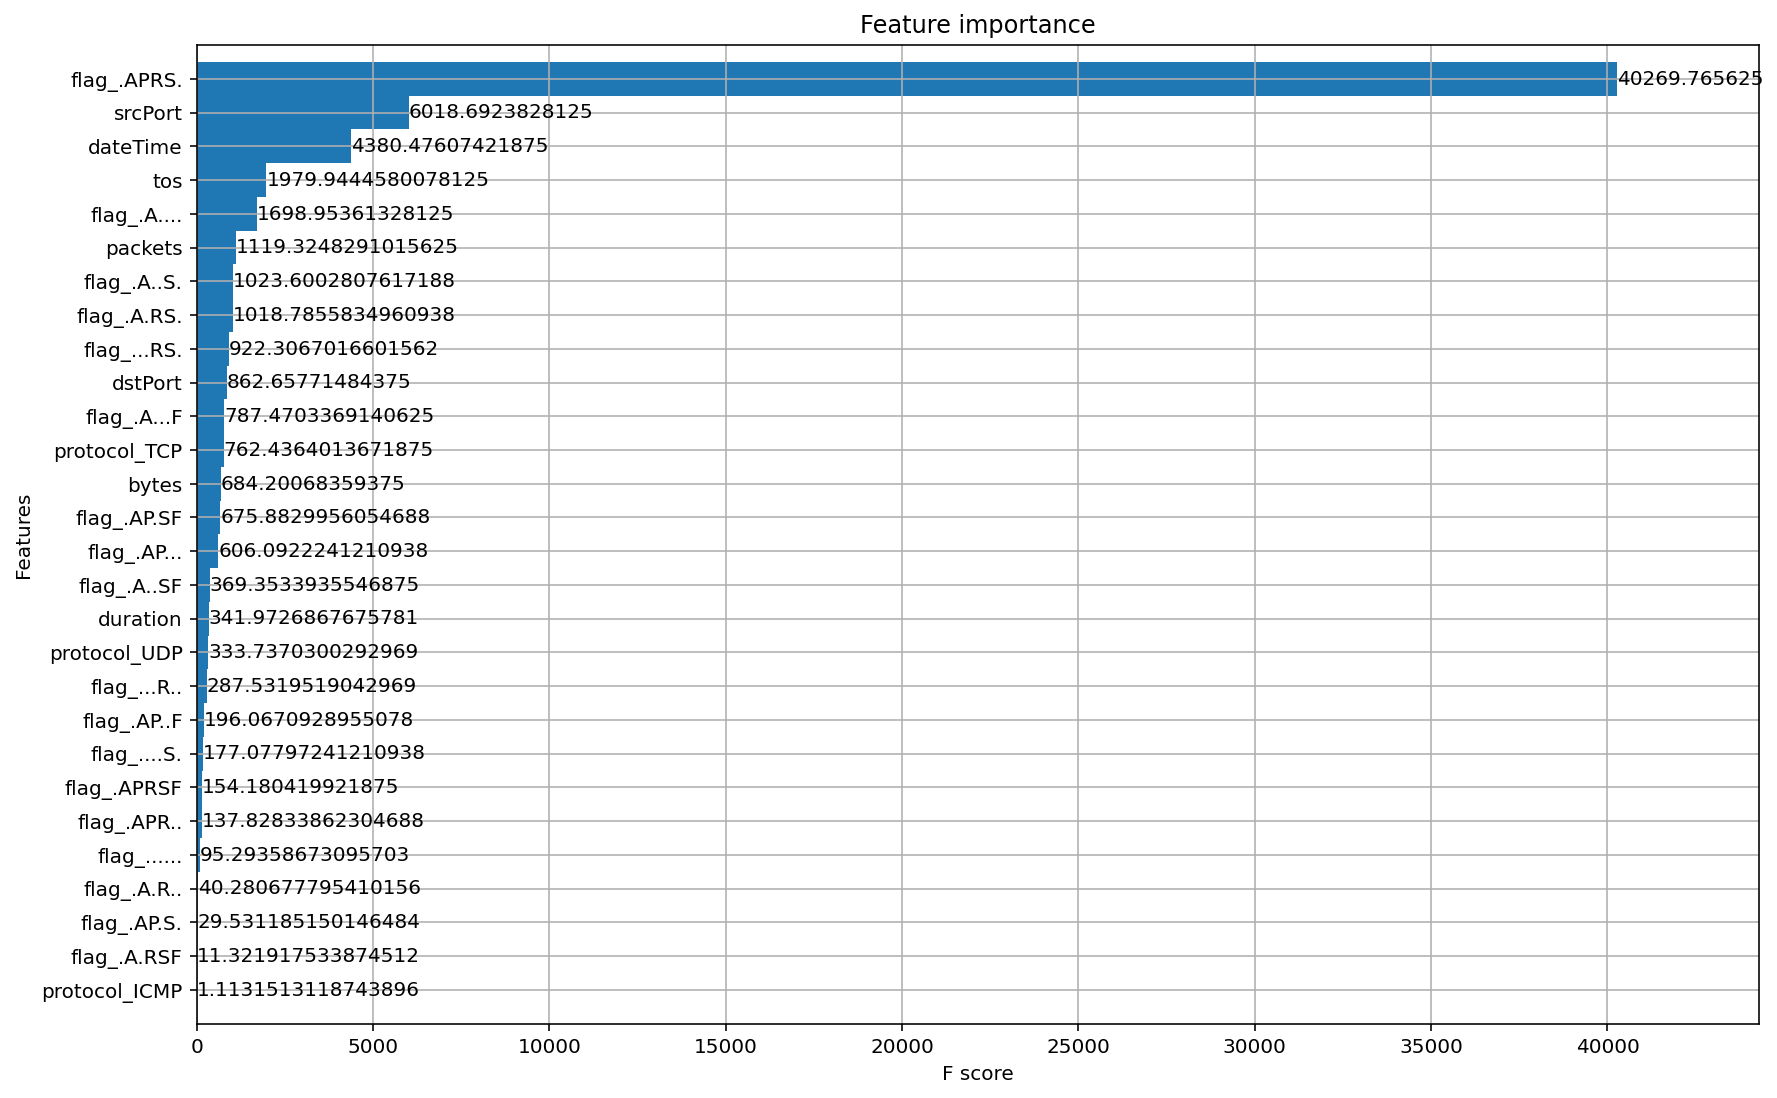

In [70]:
plotXGBoost(clf)

In [71]:
def plotXGBoost_tree(clf):
    fig = plt.figure(figsize=(20, 60))
    ax = fig.add_subplot(111)
    
    ax = xgb.plot_tree(clf, ax=ax, rankdir='LR')
    
    plt.plot()

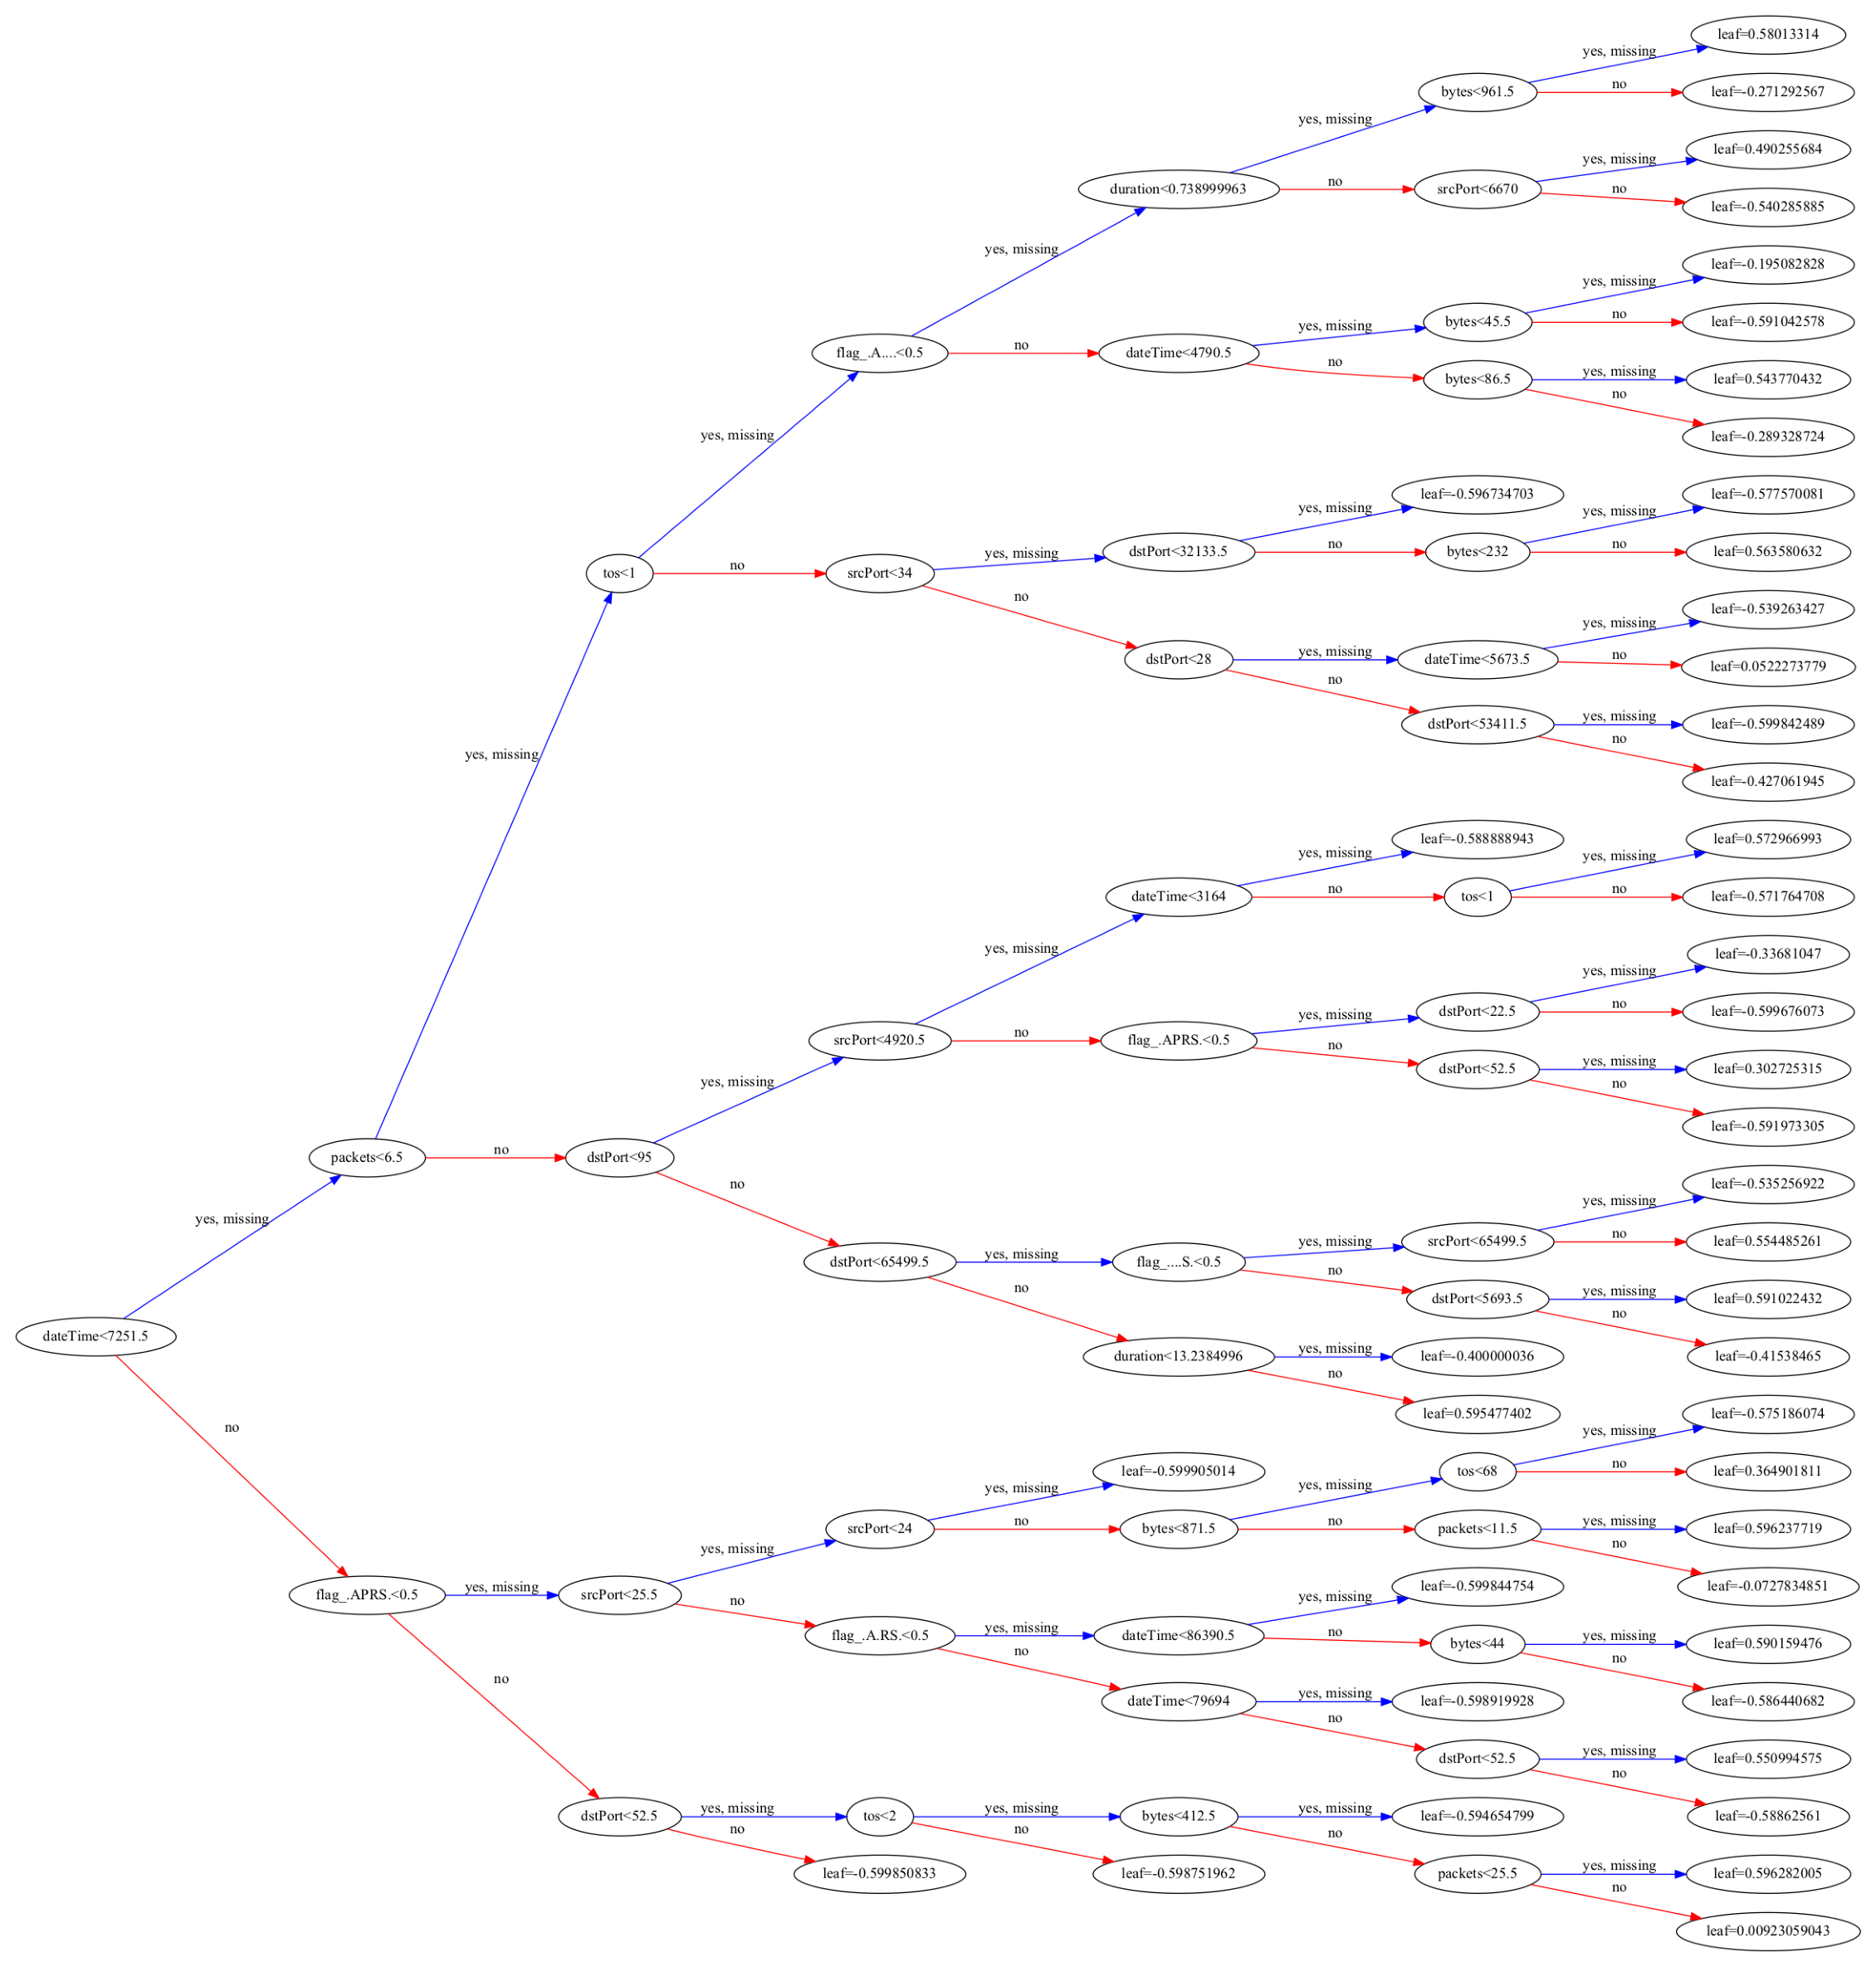

In [72]:
plotXGBoost_tree(clf)